Adapted from [ner_with_bilstm_and_crf](https://www.kaggle.com/nikkisharma536/ner-with-bilstm-and-crf/notebook)
Altigran Soares da Silva
IComp/UFAM - 15/03/2021


In [ ]:
# For this to work, use:
# Keras 2.3.1
# Also remember to use GPU in your colab notebook
%tensorflow_version 2.x

# Code to read csv file into Colaboratory:
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

from math import nan
from future.utils import iteritems
import matplotlib.pyplot as plt
import numpy as np
import math
import random
import json
import pickle
import time
from requests import get

import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import torch
from torch import cuda
from torch.utils.data import Dataset, DataLoader

!pip install sentencepiece
!pip install transformers
from transformers import BertForTokenClassification, AutoTokenizer

!pip install seqeval
from seqeval.metrics import f1_score, classification_report

Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.3 MB 14.0 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 4.7 MB 11.8 MB/s 
     |████████████████████████████████| 6.6 MB 92.2 MB/s 
     |████████████████████████████████| 120 kB 96.3 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 43 kB 1.8 MB/s 
  Created wheel for seqeval: filename=seqeval-1.2.2-py3-none-any.whl size=16180 sha256=a8c48bc380df7099bf8105ba95c1f40650b8bb50a9f4fdf485510a28509ab1b9
  Stored in directory: /root/.cache/pip/wheels/05/96/ee/7cac4e74f3b19e3158dce26a20a1c86b3533c43ec72a549fd7
Successfully built seqeval


In [ ]:
# Code to read csv file from google drive into Colaboratory:
DATA_TRAINING_FILE_ID = '1FllL2kWZ5q1E0alqyLz7TGC1qlKYwJxN'
DATA_TRAINING_FILENAME = 'ner_training_dataset.csv'
DATA_DEV_FILE_ID = '1pJS8Cc_AeixyHXgXm9uB_KaboX5E-G40'
DATA_DEV_FILENAME = 'ner_validation_dataset.csv'
DATA_TEST_FILE_ID = '1IYIIMhI1uQNjxlp9D4WzEBKLk20gE6RC'
DATA_TEST_FILENAME = 'ner_test_dataset.csv'
BACKUP_FOLDER_ID = '18ZJg_YZnxA86FdlCUMPqAvdGsXCVCDnb'

auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)
downloaded_training = drive.CreateFile({'id': DATA_TRAINING_FILE_ID})
downloaded_training.GetContentFile(DATA_TRAINING_FILENAME)
downloaded_dev = drive.CreateFile({'id': DATA_DEV_FILE_ID})
downloaded_dev.GetContentFile(DATA_DEV_FILENAME)
downloaded_test = drive.CreateFile({'id': DATA_TEST_FILE_ID})
downloaded_test.GetContentFile(DATA_TEST_FILENAME)

# Read the csv file in a dataframe called "data"
training_data = pd.read_csv(DATA_TRAINING_FILENAME, encoding="utf-8")
dev_data = pd.read_csv(DATA_DEV_FILENAME, encoding="utf-8")
test_data = pd.read_csv(DATA_TEST_FILENAME, encoding="utf-8")
# Fill NaN values using the specified method
# Ffill propagate last valid observation/value forward to next valid 
training_data = training_data.fillna(method="ffill")
dev_data = dev_data.fillna(method="ffill")
test_data = test_data.fillna(method="ffill")

notebook_filename = get('http://172.28.0.2:9000/api/sessions').json()[0]['name']

In [ ]:
# Explore the input dataset
print("Number of training sentences: ", len(training_data.groupby(['Sentence #'])))
print("Number of dev sentences: ", len(dev_data.groupby(['Sentence #'])))
print("Number of test sentences: ", len(test_data.groupby(['Sentence #'])))

training_words = list(set(training_data["Word"].values))
n_training_words = len(training_words)
print("Number of words in the training dataset: ", n_training_words)
dev_words = list(set(dev_data["Word"].values))
n_dev_words = len(dev_words)
print("Number of words in the dev dataset: ", n_dev_words)
test_words = list(set(test_data["Word"].values))
n_test_words = len(test_words)
print("Number of words in the test dataset: ", n_test_words)

training_tags = list(set(training_data["Tag"].values))
print("Tags in the training dataset:", training_tags)
n_training_tags = len(training_tags)
print("Number of Labels in the training dataset: ", n_training_tags)
dev_tags = list(set(dev_data["Tag"].values))
print("Tags in the dev dataset:", dev_tags)
n_dev_tags = len(dev_tags)
print("Number of Labels in the dev dataset: ", n_dev_tags)
test_tags = list(set(test_data["Tag"].values))
print("Tags in the test dataset:", test_tags)
n_test_tags = len(test_tags)
print("Number of Labels in the test dataset: ", n_test_tags)

print("What the training dataset looks like:")
# Show the first 10 rows
training_data.head(n=10)

Number of training sentences:  1817
Number of dev sentences:  321
Number of test sentences:  378
Number of words in the training dataset:  11597
Number of words in the dev dataset:  4202
Number of words in the test dataset:  5076
Tags in the training dataset: ['O', 'I-LEGISLACAO', 'B-LEGISLACAO']
Number of Labels in the training dataset:  3
Tags in the dev dataset: ['O', 'I-LEGISLACAO', 'B-LEGISLACAO']
Number of Labels in the dev dataset:  3
Tags in the test dataset: ['O', 'I-LEGISLACAO', 'B-LEGISLACAO']
Number of Labels in the test dataset:  3
What the training dataset looks like:


,Sentence #,Word,Tag
0,Sentence: 671,“,O
1,Sentence: 671,Agravo,O
2,Sentence: 671,regimental,O
3,Sentence: 671,em,O
4,Sentence: 671,habeas,O
5,Sentence: 671,corpus,O
6,Sentence: 671,.,O
7,Sentence: 671,Homicídio,O
8,Sentence: 671,qualificado,O
9,Sentence: 671,(,O


In [ ]:
# SentenceGetter re-organize "data" as an arry of sentences
# Each sentence is a list of pairs <word,tag> 
class SentenceGetter(object):
    
    def __init__(self, dataset):
        self.n_sent = 1
        self.dataset = dataset
        self.empty = False
        agg_func = lambda s: [(w, t) for w,t in zip(s["Word"].values.tolist(),
                                                        s["Tag"].values.tolist())]
        self.grouped = self.dataset.groupby("Sentence #").apply(agg_func)
        self.sentences = [s for s in self.grouped]
    
    def get_next(self):
        try:
            s = self.grouped["Sentence: {}".format(self.n_sent)]
            self.n_sent += 1
            return s
        except:
            return None

training_getter = SentenceGetter(training_data)
training_sentences = training_getter.sentences
dev_getter = SentenceGetter(dev_data)
dev_sentences = dev_getter.sentences
test_getter = SentenceGetter(test_data)
test_sentences = test_getter.sentences

# Example: training sentence #200 
training_sentences[200]

[('em', 'O'),
 ('seus', 'O'),
 ('votos', 'O'),
 ('os', 'O'),
 ('argumentos', 'O'),
 ('de', 'O'),
 ('ambas', 'O'),
 ('as', 'O'),
 ('partes', 'O'),
 (',', 'O'),
 ('não', 'O'),
 ('havendo', 'O'),
 ('reconhecer', 'O'),
 (',', 'O'),
 ('agora', 'O'),
 (',', 'O'),
 ('quaisquer', 'O'),
 ('dos', 'O'),
 ('vícios', 'O'),
 ('do', 'O'),
 ('art.', 'B-LEGISLACAO'),
 ('1.022', 'I-LEGISLACAO'),
 (',', 'O'),
 ('do', 'O'),
 ('Código', 'B-LEGISLACAO'),
 ('de', 'I-LEGISLACAO'),
 ('Processo', 'I-LEGISLACAO'),
 ('Civil', 'I-LEGISLACAO'),
 ('.', 'O')]

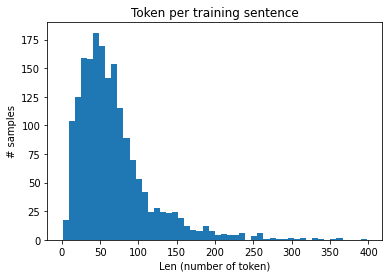

In [ ]:
# Explore set of sentences
# Plot sentences by length
plt.hist([len(s) for s in training_sentences], bins=50)
plt.title('Token per training sentence')
plt.xlabel('Len (number of token)')
plt.ylabel('# samples')
plt.show()

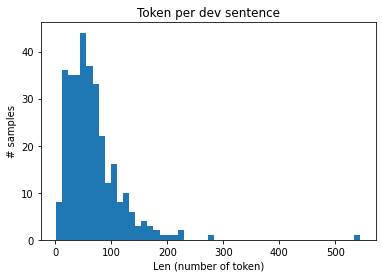

In [ ]:
# Explore set of sentences
# Plot sentences by length
plt.hist([len(s) for s in dev_sentences], bins=50)
plt.title('Token per dev sentence')
plt.xlabel('Len (number of token)')
plt.ylabel('# samples')
plt.show()

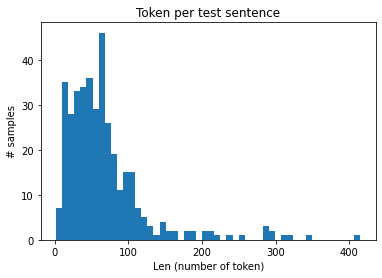

In [ ]:
# Explore set of sentences
# Plot sentences by length
plt.hist([len(s) for s in test_sentences], bins=50)
plt.title('Token per test sentence')
plt.xlabel('Len (number of token)')
plt.ylabel('# samples')
plt.show()

In [ ]:
# Keras (and most other ML packages) expect all the ids to be numeric, 
# this is an optimisation to save memory. 
# We will create the following dictionaries:
# word2idx: assign a numeric index to each word in the dataset
# idx2word: inverted version of word2idx
# tag2idx: assign a numeric index to each tag in the dataset
# idx2tag: inverted version of tag2idx

# Group training, dev and test data in order to create word-index dicts and to
# convert data to numeric indeces later
data = pd.concat([training_data, dev_data, test_data])

# words <= list of all words in the input dataset
words = list(set(data["Word"].values))
n_words = len(words)

# tags <= list of all tags in the input dataset
tags = []
for tag in set(data["Tag"].values):
    if tag is nan or isinstance(tag, float):
        tags.append('unk')
    else:
        tags.append(tag)
n_tags = len(tags)

# Dictionaries
word2idx = {w: i for i, w in enumerate(words)}
idx2word = {i: w for w, i in iteritems(word2idx)}
tag2idx = {t: i for i, t in enumerate(tags)}
idx2tag = {v: k for k, v in iteritems(tag2idx)}

# Index number for the word 'civil'
print(word2idx['civil'])
# Word of index 10
print(idx2word[10])
# Index number for the tag 'B-LEGISLACAO'
print(tag2idx['B-LEGISLACAO'])
# Tag of index 0
print(idx2tag[0])

7251
corrige
2
O


In [ ]:
# Convert train, dev and test data to numeric values
X_train = [[word2idx[w[0]] for w in s] for s in training_sentences]
y_train = [[tag2idx[w[1]] for w in s] for s in training_sentences]

X_dev = [[word2idx[w[0]] for w in s] for s in dev_sentences]
y_dev = [[tag2idx[w[1]] for w in s] for s in dev_sentences]

X_test = [[word2idx[w[0]] for w in s] for s in test_sentences]
y_test = [[tag2idx[w[1]] for w in s] for s in test_sentences]

In [ ]:
# Use this function to randomly remove some points from training dataset
# Use removal percentage in decimal value. E.g.: if you set as 0.5, it will
# remove 50% of the dataset

def random_remove_data_points(dataset, labels, removal_percentage):
    if removal_percentage < 0 or removal_percentage > 1:
        raise Exception("Invalid removal percentage")
    
    if removal_percentage == 1:
        raise Exception("You can't remove the entire dataset")
    
    number_of_points_remaining = round(len(dataset)*(1-removal_percentage))

    try_again = True

    while try_again:
      random_idxs = np.random.choice(len(dataset), number_of_points_remaining, replace=False)
      cut_dataset_sentences = [dataset[i] for i in random_idxs]
      cut_dataset_labels = [labels[i] for i in random_idxs]
      cut_tags = list(set([idx2tag[j] for sub in cut_dataset_labels for j in sub]))

      if all(i in cut_tags for i in tags if i[:2] == "B-"):
        try_again = False

    return cut_dataset_sentences, cut_dataset_labels 

print(f"Points in X_train before removal: {len(X_train)}")
print(f"Points in y_train before removal: {len(y_train)}")
X_train, y_train = random_remove_data_points(X_train, y_train, 0.9174)
print(f"Points in X_train before removal: {len(X_train)}")
print(f"Points in y_train before removal: {len(y_train)}")

Points in X_train before removal: 1817
Points in y_train before removal: 1817
Points in X_train before removal: 150
Points in y_train before removal: 150


In [ ]:
# Aux functions to save data and dicts, if data consistency is important
# and there is desire to not random split again

def save_backup_dataset(dataset, filename):
  dataset_df = pd.DataFrame(dataset)
  dataset_df.to_csv(filename, index=False)
  gfile = drive.CreateFile({'parents': [{'id': BACKUP_FOLDER_ID}]})
  gfile.SetContentFile(filename)
  gfile.Upload()

def save_backup_dict(dict, filename):
  dict_file = open(filename, "wb")
  pickle.dump(dict, dict_file)
  dict_file.close()
  gfile = drive.CreateFile({'parents': [{'id': BACKUP_FOLDER_ID}]})
  gfile.SetContentFile(filename)
  gfile.Upload()

In [ ]:
# Uncomment this cell if you want to save data for further use

# Check some points before saving
print(X_train[0])
print(y_train[0])
print(X_dev[0])
print(y_dev[0])
print(X_test[0])
print(y_test[0])
print(word2idx['civil'])
print(tag2idx['B-LEGISLACAO'])
print(idx2tag[0])
print(idx2word[100])
print(n_words)
print(n_tags)

X_train_filename = f'{notebook_filename}_X_train.csv'
y_train_filename = f'{notebook_filename}_y_train.csv'
X_dev_filename = f'{notebook_filename}_X_dev.csv'
y_dev_filename = f'{notebook_filename}_y_dev.csv'
X_test_filename = f'{notebook_filename}_X_test.csv'
y_test_filename = f'{notebook_filename}_y_test.csv'

word2idx_filename = f'{notebook_filename}_word2idx.pkl'
idx2word_filename = f'{notebook_filename}_idx2word.pkl'
tag2idx_filename = f'{notebook_filename}_tag2idx.pkl'
idx2tag_filename = f'{notebook_filename}_idx2tag.pkl'

others_filename = f'{notebook_filename}_others.pkl'

save_backup_dataset(X_train, X_train_filename)
save_backup_dataset(y_train, y_train_filename)
save_backup_dataset(X_dev, X_dev_filename)
save_backup_dataset(y_dev, y_dev_filename)
save_backup_dataset(X_test, X_test_filename)
save_backup_dataset(y_test, y_test_filename)

save_backup_dict(word2idx, word2idx_filename)
save_backup_dict(idx2word, idx2word_filename)
save_backup_dict(tag2idx, tag2idx_filename)
save_backup_dict(idx2tag, idx2tag_filename)

save_backup_dict({"n_words":n_words, "n_tags":n_tags}, others_filename)

[4164, 2427, 11864, 6718, 10124, 1092, 10580, 11641, 1092, 3844, 951, 565, 1092, 1596, 5358, 1596, 6718, 6147, 1092, 10271, 1092, 4648, 10860, 13339, 1820, 1092, 951, 10562, 10860, 12152, 6718]
[0, 0, 2, 1, 1, 0, 2, 1, 0, 2, 0, 2, 0, 0, 0, 0, 0, 2, 0, 2, 0, 0, 0, 2, 1, 0, 0, 0, 0, 2, 0]
[10013, 2687, 1092, 8241, 1453, 10863, 10305, 6574, 97, 972, 11252, 6261, 586, 19, 5282, 972, 4308, 972, 5452, 12002, 1092, 12207, 10557, 155, 1711, 9033, 419, 12057, 1037, 972, 2082, 8866, 116, 2675, 10011, 4212, 1323, 5298, 972, 10330, 8277, 419, 5315, 1092, 419, 701, 1092, 4412, 951, 419, 7449, 2765, 2987, 6746, 13344, 13082, 11820, 8457, 7487, 11990, 1092, 13059, 1092, 13344, 7411, 355, 8626, 7487, 1607, 13344, 7411, 12959, 951, 7487, 7331, 10860, 3323, 2503, 6718]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 1, 0, 2, 0, 0, 2, 1, 0, 2, 1, 0, 2, 1, 0, 2, 1, 0, 2, 0, 0]


In [1]:
# Uncomment this cell if you want to load saved data

# Re-import necessary libs
import pandas as pd
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
import pickle, math
from requests import get
import numpy as np
import matplotlib.pyplot as plt
import random
import time
%tensorflow_version 2.x
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import torch
from torch import cuda
from torch.utils.data import Dataset, DataLoader
!pip install sentencepiece
!pip install transformers
from transformers import BertForTokenClassification, AutoTokenizer
import matplotlib.pyplot as plt
!pip install seqeval
from seqeval.metrics import f1_score, classification_report

BACKUP_FOLDER_ID = '18ZJg_YZnxA86FdlCUMPqAvdGsXCVCDnb'
notebook_filename = get('http://172.28.0.2:9000/api/sessions').json()[0]['name']

X_train_filename = f'{notebook_filename}_X_train.csv'
y_train_filename = f'{notebook_filename}_y_train.csv'
X_dev_filename = f'{notebook_filename}_X_dev.csv'
y_dev_filename = f'{notebook_filename}_y_dev.csv'
X_test_filename = f'{notebook_filename}_X_test.csv'
y_test_filename = f'{notebook_filename}_y_test.csv'

word2idx_filename = f'{notebook_filename}_word2idx.pkl'
idx2word_filename = f'{notebook_filename}_idx2word.pkl'
tag2idx_filename = f'{notebook_filename}_tag2idx.pkl'
idx2tag_filename = f'{notebook_filename}_idx2tag.pkl'

others_filename = f'{notebook_filename}_others.pkl'

# Re-get important variables
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

def get_backup_files_ids(folder_id):
  file_list = drive.ListFile({'q': "'{}' in parents and trashed=false".format(folder_id)}).GetList()
  return file_list

def load_backup_dataset(file_id):
  downloaded = drive.CreateFile({'id':file_id})
  downloaded.GetContentFile(f"{file_id}.csv")

  dataset = pd.read_csv(f"{file_id}.csv", encoding="latin1")
  dataset = dataset.values.tolist()
  dataset = [ [ int(word) for word in sentence if str(word) != 'nan' ] for sentence in dataset]
  return dataset

def load_backup_dict(file_id):
  downloaded = drive.CreateFile({'id':file_id})
  downloaded.GetContentFile(f"{file_id}.pkl")

  dict_file = open(f"{file_id}.pkl", "rb")
  out_dict = pickle.load(dict_file)
  return out_dict

backup_file_list = get_backup_files_ids(BACKUP_FOLDER_ID)

X_train_file_id = [backup_file for backup_file in backup_file_list if backup_file['title'] == X_train_filename][0]['id']
y_train_file_id = [backup_file for backup_file in backup_file_list if backup_file['title'] == y_train_filename][0]['id']
X_dev_file_id = [backup_file for backup_file in backup_file_list if backup_file['title'] == X_dev_filename][0]['id']
y_dev_file_id = [backup_file for backup_file in backup_file_list if backup_file['title'] == y_dev_filename][0]['id']
X_test_file_id = [backup_file for backup_file in backup_file_list if backup_file['title'] == X_test_filename][0]['id']
y_test_file_id = [backup_file for backup_file in backup_file_list if backup_file['title'] == y_test_filename][0]['id']

word2idx_file_id = [backup_file for backup_file in backup_file_list if backup_file['title'] == word2idx_filename][0]['id']
idx2word_file_id = [backup_file for backup_file in backup_file_list if backup_file['title'] == idx2word_filename][0]['id']
tag2idx_file_id = [backup_file for backup_file in backup_file_list if backup_file['title'] == tag2idx_filename][0]['id']
idx2tag_file_id = [backup_file for backup_file in backup_file_list if backup_file['title'] == idx2tag_filename][0]['id']

others_file_id = [backup_file for backup_file in backup_file_list if backup_file['title'] == others_filename][0]['id']

X_train = load_backup_dataset(X_train_file_id)
y_train = load_backup_dataset(y_train_file_id)
X_dev = load_backup_dataset(X_dev_file_id)
y_dev = load_backup_dataset(y_dev_file_id)
X_test = load_backup_dataset(X_test_file_id)
y_test = load_backup_dataset(y_test_file_id)

word2idx = load_backup_dict(word2idx_file_id)
idx2word = load_backup_dict(idx2word_file_id)
tag2idx = load_backup_dict(tag2idx_file_id)
idx2tag = load_backup_dict(idx2tag_file_id)

others = load_backup_dict(others_file_id)

n_words = others["n_words"]
n_tags = others["n_tags"]

# Check some points after loading data to see if they match the ones before saving
print(X_train[0])
print(y_train[0])
print(X_dev[0])
print(y_dev[0])
print(X_test[0])
print(y_test[0])
print(word2idx['civil'])
print(tag2idx['B-LEGISLACAO'])
print(idx2tag[0])
print(idx2word[100])
print(n_words)
print(n_tags)

Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.3 MB 14.7 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 4.7 MB 14.4 MB/s 
     |████████████████████████████████| 6.6 MB 52.9 MB/s 
     |████████████████████████████████| 120 kB 73.8 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 43 kB 2.2 MB/s 
  Created wheel for seqeval: filename=seqeval-1.2.2-py3-none-any.whl size=16180 sha256=1ca98dd9379979ffddb90730c6a5b89109b0dbdf95235b23d88615f4ca1504ae
  Stored in directory: /root/.cache/pip/wheels/05/96/ee/7cac4e74f3b19e3158dce26a20a1c86b3533c43ec72a549fd7
Successfully built seqeval
[4164, 2427, 11864, 6718, 10124, 1092, 10580, 11641, 1092,

In [2]:
# Aux function to help in augmentation. Generates a dict where entities
# are the keys, and words are the values.

def create_entities_dict(dataset, labels, decoded_word=False):
    entities_dict = {}
    
    for i, sentence in enumerate(dataset):
        for k, word in enumerate(sentence):
            tag = idx2tag[labels[i][k]]
            if tag[:2] == "B-":
                if decoded_word:
                    word_list = [idx2word[word]]
                else:
                    word_list = [word]
                j = k + 1
                if j < len(labels[i]):
                    while idx2tag[labels[i][j]][:2] == "I-":
                        if decoded_word:
                            word_list.append(idx2word[dataset[i][j]])
                        else:
                            word_list.append(dataset[i][j])
                        j = j+1
                        if j == len(labels[i]):
                            break
                        
                if entities_dict.get(tag):
                    if word_list not in entities_dict[tag]:
                        entities_dict[tag].append(word_list)
                else:
                    entities_dict[tag] = [word_list]
                    
    return entities_dict

entities_dict = create_entities_dict(X_train, y_train)

In [3]:
# Augmentation function using entity replacement technique.
# It will generate a new dataset, with X% more points based on
# the original dataset. E.g.: if you set augmentation percentage as 0.5 and dataset has
# 1000 points, it will generate a dataset with 1500 points.

def generate_sentences(dataset, labels, entities_dict, augmented_set_size_percentage):
    if augmented_set_size_percentage < 0:
        raise Exception("Invalid augmented set size percentage")

    number_of_new_sentences = math.ceil(augmented_set_size_percentage * len(dataset))
    random_idxs = np.random.choice(len(dataset), number_of_new_sentences, replace=True)
    
    base_sequences = [dataset[i] for i in random_idxs]
    base_labels = [labels[i] for i in random_idxs]

    new_sequences = []
    new_labels = []
    
    for k, sequence in enumerate(base_sequences):
        new_sequence = []
        new_label = []

        for i, word in enumerate(sequence):
            tag = idx2tag[base_labels[k][i]]
            if tag == "O":
                new_sequence.append(word)
                new_label.append(base_labels[k][i])
            elif tag[:2] == "B-":
                same_entities_type_tmp = entities_dict[tag]
                same_entities_type = np.array(same_entities_type_tmp, dtype=object)
                random_entity_idx = np.random.choice(len(same_entities_type), 1)[0]
                random_entity = same_entities_type[random_entity_idx]
                random_number_of_tokens = random.randint(1, len(random_entity))
                random_entity_tokens = np.random.choice(random_entity, random_number_of_tokens, replace = False).tolist()
                entity = tag[2:]
                decoded_token_labels = [f"I-{entity}" for token in random_entity_tokens]
                decoded_token_labels[0] = tag
                encoded_token_labels = [tag2idx[label] for label in decoded_token_labels]
                new_sequence = new_sequence + random_entity_tokens
                new_label = new_label + encoded_token_labels

        new_sequences.append(new_sequence)
        new_labels.append(new_label)

    augmented_X_train = dataset + new_sequences
    augmented_y_train = labels + new_labels

    print(f"Points in X_train after augmentation: {len(augmented_X_train)}")
    print(f"Points in y_train after augmentation: {len(augmented_y_train)}")

    return augmented_X_train, augmented_y_train

In [4]:
tokenizer = AutoTokenizer.from_pretrained("bert-base-multilingual-cased")

class dataset(Dataset):
  def __init__(self, dataframe, tokenizer, max_len):
        self.len = len(dataframe)
        self.data = dataframe
        self.tokenizer = tokenizer
        self.max_len = max_len

  def __getitem__(self, index):
        # step 1: get the sentence and word labels
        sentence = self.data.sentence[index]
        word_labels = self.data.word_labels[index].split(",") 

        # step 2: use tokenizer to encode sentence (includes padding/truncation up to max length)
        # BertTokenizerFast provides a handy "return_offsets_mapping" functionality for individual tokens
        encoding = self.tokenizer(sentence,
                             is_split_into_words=True,
                             return_offsets_mapping=True, 
                             padding='max_length', 
                             truncation=True, 
                             max_length=self.max_len)
        
        # step 3: create token labels only for first word pieces of each tokenized word
        labels = [tag2idx[label] for label in word_labels] 
        # code based on https://huggingface.co/transformers/custom_datasets.html#tok-ner
        # create an empty array of -100 of length max_length
        encoded_labels = np.ones(len(encoding["offset_mapping"]), dtype=int) * -100
        
        # set only labels whose first offset position is 0 and the second is not 0
        i = 0
        for idx, mapping in enumerate(encoding["offset_mapping"]):
          if mapping[0] == 0 and mapping[1] != 0:
            # overwrite label
            encoded_labels[idx] = labels[i]
            i += 1

        # step 4: turn everything into PyTorch tensors
        item = {key: torch.as_tensor(val) for key, val in encoding.items()}
        item['labels'] = torch.as_tensor(encoded_labels)
        
        return item

  def __len__(self):
        return self.len

In [5]:
# some configuration variables
LEARNING_RATE = 5e-05
MAX_GRAD_NORM = 10
TRAINING_STOP_LOSS_PERCENTAGE = 1

# Model creation function
def create_model(maxlen, n_labels, training_set, testing_set, validation_set):
  device = 'cuda' if cuda.is_available() else 'cpu'
  print("Device: ", device)

  model = BertForTokenClassification.from_pretrained('bert-base-multilingual-cased', num_labels=n_labels)
  model.to(device)

  optimizer = torch.optim.Adam(params=model.parameters(), lr=LEARNING_RATE)

  TRAIN_BATCH_SIZE = round(0.05*len(training_set))
  if TRAIN_BATCH_SIZE > 16:
    TRAIN_BATCH_SIZE = 16
  if TRAIN_BATCH_SIZE < 10:
    TRAIN_BATCH_SIZE = 10

  VALID_BATCH_SIZE = round(0.1*len(validation_set))
  if VALID_BATCH_SIZE > 16:
    VALID_BATCH_SIZE = 16
  if VALID_BATCH_SIZE < 10:
    VALID_BATCH_SIZE = 10

  train_params = {'batch_size': TRAIN_BATCH_SIZE,
                  'shuffle': True,
                  'num_workers': 0
                  }

  test_params = {'batch_size': VALID_BATCH_SIZE,
                  'shuffle': True,
                  'num_workers': 0
                  }

  training_loader = DataLoader(training_set, **train_params)
  testing_loader = DataLoader(testing_set, **test_params)
  validation_loader = DataLoader(validation_set, **test_params)

  return model, device, optimizer, training_loader, testing_loader, validation_loader

In [6]:
# Model training function
def train(model, device, optimizer, training_loader, epoch, training_stop_loss_percentage):
    tr_loss, tr_accuracy = 0, 0
    nb_tr_examples, nb_tr_steps = 0, 0
    tr_preds, tr_labels = [], []
    losses = []
    # put model in training mode
    model.train()
    
    for idx, batch in enumerate(training_loader):
        
        ids = batch['input_ids'].to(device, dtype = torch.long)
        mask = batch['attention_mask'].to(device, dtype = torch.long)
        labels = batch['labels'].to(device, dtype = torch.long)

        loss, tr_logits = model(input_ids=ids, attention_mask=mask, labels=labels, return_dict = False)
        tr_loss += loss.item()

        nb_tr_steps += 1
        nb_tr_examples += labels.size(0)
        
        if idx % 100==0:
            loss_step = tr_loss/nb_tr_steps
            print(f"Training loss per 100 training steps: {loss_step}")
            losses.append(loss_step)
            last_5_losses = losses[-5:]
            loss_min = min(last_5_losses)
            loss_max = max(last_5_losses)
            if len(last_5_losses) > 1 and (loss_max - loss_min)/loss_max < training_stop_loss_percentage/100:
              print("Stopping epoch...")
              break
           
        # compute training accuracy
        flattened_targets = labels.view(-1) # shape (batch_size * seq_len,)
        active_logits = tr_logits.view(-1, model.num_labels) # shape (batch_size * seq_len, num_labels)
        flattened_predictions = torch.argmax(active_logits, axis=1) # shape (batch_size * seq_len,)
        
        # only compute accuracy at active labels
        active_accuracy = labels.view(-1) != -100 # shape (batch_size, seq_len)
        #active_labels = torch.where(active_accuracy, labels.view(-1), torch.tensor(-100).type_as(labels))
        
        labels = torch.masked_select(flattened_targets, active_accuracy)
        predictions = torch.masked_select(flattened_predictions, active_accuracy)
        
        tr_labels.extend(labels)
        tr_preds.extend(predictions)

        tmp_tr_accuracy = accuracy_score(labels.cpu().numpy(), predictions.cpu().numpy())
        tr_accuracy += tmp_tr_accuracy
    
        # gradient clipping
        torch.nn.utils.clip_grad_norm_(
            parameters=model.parameters(), max_norm=MAX_GRAD_NORM
        )
        
        # backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    epoch_loss = tr_loss / nb_tr_steps
    tr_accuracy = tr_accuracy / nb_tr_steps
    print(f"Training loss epoch: {epoch_loss}")
    print(f"Training accuracy epoch: {tr_accuracy}")

In [7]:
# Model testing function
def test(model, device, testing_loader):
    print("Validating model...")
    # put model in evaluation mode
    model.eval()
    
    eval_loss, eval_accuracy = 0, 0
    nb_eval_examples, nb_eval_steps = 0, 0
    eval_preds, eval_labels = [], []
    
    with torch.no_grad():
        for idx, batch in enumerate(testing_loader):
            
            ids = batch['input_ids'].to(device, dtype = torch.long)
            mask = batch['attention_mask'].to(device, dtype = torch.long)
            labels = batch['labels'].to(device, dtype = torch.long)
            
            loss, eval_logits = model(input_ids=ids, attention_mask=mask, labels=labels, return_dict = False)
            
            eval_loss += loss.item()

            nb_eval_steps += 1
            nb_eval_examples += labels.size(0)
        
            # compute evaluation accuracy
            flattened_targets = labels.view(-1) # shape (batch_size * seq_len,)
            active_logits = eval_logits.view(-1, model.num_labels) # shape (batch_size * seq_len, num_labels)
            flattened_predictions = torch.argmax(active_logits, axis=1) # shape (batch_size * seq_len,)
            
            # only compute accuracy at active labels
            active_accuracy = labels.view(-1) != -100 # shape (batch_size, seq_len)
        
            labels = torch.masked_select(flattened_targets, active_accuracy)
            predictions = torch.masked_select(flattened_predictions, active_accuracy)
            
            eval_labels.extend(labels)
            eval_preds.extend(predictions)
            
            tmp_eval_accuracy = accuracy_score(labels.cpu().numpy(), predictions.cpu().numpy())
            eval_accuracy += tmp_eval_accuracy

    labels = [idx2tag[id.item()] for id in eval_labels]
    predictions = [idx2tag[id.item()] for id in eval_preds]
    
    eval_loss = eval_loss / nb_eval_steps
    eval_accuracy = eval_accuracy / nb_eval_steps
    print(f"Validation Loss: {eval_loss}")
    print(f"Validation Accuracy: {eval_accuracy}")

    return labels, predictions, eval_loss

In [8]:
def create_train_and_validate_model(augmented_percentage):

  augmented_X_train, augmented_y_train = generate_sentences(X_train, y_train, entities_dict, augmented_percentage)

  maxlen_X_train = max([len(s) for s in augmented_X_train])
  maxlen_X_test = max([len(s) for s in X_test])
  maxlen_X_dev = max([len(s) for s in X_dev])
  maxlen_y_train = max([len(s) for s in augmented_y_train])
  maxlen_y_test = max([len(s) for s in y_test])
  maxlen_y_dev = max([len(s) for s in y_dev])

  maxlen = max([maxlen_X_train, maxlen_X_test, maxlen_X_dev, maxlen_y_train, maxlen_y_test, maxlen_y_dev])

  if maxlen > 512:
    maxlen = 512

  augmented_X_train_words = [[idx2word[word] for word in sentence] for sentence in augmented_X_train]
  X_dev_words = [[idx2word[word] for word in sentence] for sentence in X_dev]
  X_test_words = [[idx2word[word] for word in sentence] for sentence in X_test]
  augmented_y_train_tags = [','.join([idx2tag[tag] for tag in sentence]) for sentence in augmented_y_train]
  y_dev_tags = [','.join([idx2tag[tag] for tag in sentence]) for sentence in y_dev]
  y_test_tags = [','.join([idx2tag[tag] for tag in sentence]) for sentence in y_test]

  new_train_df = pd.DataFrame({"sentence": augmented_X_train_words, "word_labels": augmented_y_train_tags}).reset_index(drop=True)
  new_test_df = pd.DataFrame({"sentence": X_test_words, "word_labels": y_test_tags}).reset_index(drop=True)
  new_val_df = pd.DataFrame({"sentence": X_dev_words, "word_labels": y_dev_tags}).reset_index(drop=True)

  training_set = dataset(new_train_df, tokenizer, maxlen)
  testing_set = dataset(new_test_df, tokenizer, maxlen)
  validation_set = dataset(new_val_df, tokenizer, maxlen)

  model, device, optimizer, training_loader, testing_loader, val_loader = create_model(maxlen, len(tag2idx), training_set, testing_set, validation_set)

  training_start_time = time.clock()
  min_val_loss = 0
  MAX_PATIENCE = 5
  patience = 0

  for epoch in range(100):
    print(f"Training epoch: {epoch + 1}")
    if patience == MAX_PATIENCE:
      print("Patience limit reached")
      break
    train(model, device, optimizer, training_loader, epoch, TRAINING_STOP_LOSS_PERCENTAGE)
    labels, predictions, val_loss = test(model, device, val_loader)
    if ((min_val_loss == 0) or (min_val_loss != 0 and val_loss < min_val_loss)):
      min_val_loss = val_loss
      torch.save(model.state_dict(), 'checkpoint.pt')
      patience = 0
    else:
      patience = patience + 1
  print(f"Training duration: {(time.clock() - training_start_time)/60} minutes")

  checkpoint = torch.load('checkpoint.pt')
  model.load_state_dict(checkpoint)

  validation_start_time = time.clock()
  labels, predictions, test_loss = test(model, device, testing_loader)
  labels = [labels]
  predictions = [predictions]
  print(f"Validation duration: {(time.clock() - validation_start_time)/60} minutes")

  print("F1-score (test): {:.1%}".format(f1_score(labels, predictions)))
  print(classification_report(labels, predictions))

In [9]:
number_of_training_models = 10
target_augmented_percentage = 0

print(f"!!!!!! Augmented Percentage {target_augmented_percentage*100}% !!!!!!")

for i in range(number_of_training_models):
  print(f"!!!!!! Starting model number {i+1} !!!!!!")
  create_train_and_validate_model(target_augmented_percentage)

!!!!!! Augmented Percentage 0% !!!!!!
!!!!!! Starting model number 1 !!!!!!
Points in X_train after augmentation: 150
Points in y_train after augmentation: 150
Device:  cuda


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForTokenClassification: ['cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at 

Training epoch: 1
Training loss per 100 training steps: 0.9916214942932129
Training loss epoch: 0.31617105603218076
Training accuracy epoch: 0.8998671267568075
Validating model...
Validation Loss: 0.16741533435526348
Validation Accuracy: 0.9365395270227123
Training epoch: 2
Training loss per 100 training steps: 0.11874059587717056
Training loss epoch: 0.08414712150891622
Training accuracy epoch: 0.9737365689285274
Validating model...
Validation Loss: 0.051958185964308325
Validation Accuracy: 0.9843331037280445
Training epoch: 3
Training loss per 100 training steps: 0.022546010091900826
Training loss epoch: 0.02776464351142446
Training accuracy epoch: 0.9905632030111747
Validating model...
Validation Loss: 0.06196169958760341
Validation Accuracy: 0.9822085122924222
Training epoch: 4
Training loss per 100 training steps: 0.034207236021757126
Training loss epoch: 0.01154070971533656
Training accuracy epoch: 0.9964252353522468
Validating model...
Validation Loss: 0.03393003549371358
Valida

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.039129225246142596
Validation Accuracy: 0.989680465108277
Validation duration: 0.12028625000000043 minutes
F1-score (test): 92.5%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

  LEGISLACAO       0.89      0.96      0.92      1238

   micro avg       0.89      0.96      0.92      1238
   macro avg       0.89      0.96      0.92      1238
weighted avg       0.89      0.96      0.92      1238

!!!!!! Starting model number 2 !!!!!!
Points in X_train after augmentation: 150
Points in y_train after augmentation: 150
Device:  cuda


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForTokenClassification: ['cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at 

Training epoch: 1
Training loss per 100 training steps: 1.054085612297058
Training loss epoch: 0.3285861680905024
Training accuracy epoch: 0.8953097913336668
Validating model...
Validation Loss: 0.13559631825912566
Validation Accuracy: 0.9516692361382683
Training epoch: 2
Training loss per 100 training steps: 0.14410996437072754
Training loss epoch: 0.07832093524436155
Training accuracy epoch: 0.9772728947618283
Validating model...
Validation Loss: 0.04480645823336783
Validation Accuracy: 0.9871351534805186
Training epoch: 3
Training loss per 100 training steps: 0.017786122858524323
Training loss epoch: 0.02968741524964571
Training accuracy epoch: 0.9908878494989352
Validating model...
Validation Loss: 0.04063436604060587
Validation Accuracy: 0.9890336135470408
Training epoch: 4
Training loss per 100 training steps: 0.007870085537433624
Training loss epoch: 0.013683869565526644
Training accuracy epoch: 0.9960920343585411
Validating model...
Validation Loss: 0.03531875380126405
Validati

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.0381560834745566
Validation Accuracy: 0.9909791446769992
Validation duration: 0.12196488333333283 minutes
F1-score (test): 93.2%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

  LEGISLACAO       0.92      0.95      0.93      1238

   micro avg       0.92      0.95      0.93      1238
   macro avg       0.92      0.95      0.93      1238
weighted avg       0.92      0.95      0.93      1238

!!!!!! Starting model number 3 !!!!!!
Points in X_train after augmentation: 150
Points in y_train after augmentation: 150
Device:  cuda


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForTokenClassification: ['cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at 

Training epoch: 1
Training loss per 100 training steps: 1.3867998123168945
Training loss epoch: 0.34159053564071656
Training accuracy epoch: 0.8739054438934704
Validating model...
Validation Loss: 0.13408144598915464
Validation Accuracy: 0.9537444265013383
Training epoch: 2
Training loss per 100 training steps: 0.07458754628896713
Training loss epoch: 0.09332321373124917
Training accuracy epoch: 0.9714467971945289
Validating model...
Validation Loss: 0.06405519383649032
Validation Accuracy: 0.9798055184163899
Training epoch: 3
Training loss per 100 training steps: 0.04913781210780144
Training loss epoch: 0.03566152617956201
Training accuracy epoch: 0.9905486518694345
Validating model...
Validation Loss: 0.03867967301491825
Validation Accuracy: 0.9889875821973177
Training epoch: 4
Training loss per 100 training steps: 0.03345000371336937
Training loss epoch: 0.015365052223205566
Training accuracy epoch: 0.9957515723419715
Validating model...
Validation Loss: 0.03521356476648223
Validati

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.039328871333661176
Validation Accuracy: 0.9911700999410478
Validation duration: 0.12194059999999922 minutes
F1-score (test): 93.0%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

  LEGISLACAO       0.91      0.95      0.93      1238

   micro avg       0.91      0.95      0.93      1238
   macro avg       0.91      0.95      0.93      1238
weighted avg       0.91      0.95      0.93      1238

!!!!!! Starting model number 4 !!!!!!
Points in X_train after augmentation: 150
Points in y_train after augmentation: 150
Device:  cuda


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForTokenClassification: ['cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at 

Training epoch: 1
Training loss per 100 training steps: 0.9237139225006104
Training loss epoch: 0.32873566150665284
Training accuracy epoch: 0.8997491415844223
Validating model...
Validation Loss: 0.16179373505569639
Validation Accuracy: 0.9504809600923348
Training epoch: 2
Training loss per 100 training steps: 0.36689290404319763
Training loss epoch: 0.10970599080125491
Training accuracy epoch: 0.9675125209119027
Validating model...
Validation Loss: 0.07035116824720587
Validation Accuracy: 0.9786911989344805
Training epoch: 3
Training loss per 100 training steps: 0.04377451911568642
Training loss epoch: 0.04136510143677394
Training accuracy epoch: 0.9889279070382379
Validating model...
Validation Loss: 0.040750316854211543
Validation Accuracy: 0.9895412129961284
Training epoch: 4
Training loss per 100 training steps: 0.013381289318203926
Training loss epoch: 0.021507620035360258
Training accuracy epoch: 0.9936592360007552
Validating model...
Validation Loss: 0.05127847890946127
Valida

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.03759653643161679
Validation Accuracy: 0.9926241771186387
Validation duration: 0.12031778333333326 minutes
F1-score (test): 94.4%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

  LEGISLACAO       0.94      0.95      0.94      1238

   micro avg       0.94      0.95      0.94      1238
   macro avg       0.94      0.95      0.94      1238
weighted avg       0.94      0.95      0.94      1238

!!!!!! Starting model number 5 !!!!!!
Points in X_train after augmentation: 150
Points in y_train after augmentation: 150
Device:  cuda


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForTokenClassification: ['cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at 

Training epoch: 1
Training loss per 100 training steps: 1.2386434078216553
Training loss epoch: 0.2980424165725708
Training accuracy epoch: 0.8803011259828134
Validating model...
Validation Loss: 0.11198228775035768
Validation Accuracy: 0.9599480757313723
Training epoch: 2
Training loss per 100 training steps: 0.12765726447105408
Training loss epoch: 0.061602176477511726
Training accuracy epoch: 0.9814008777134944
Validating model...
Validation Loss: 0.043028955281312974
Validation Accuracy: 0.9875386738157947
Training epoch: 3
Training loss per 100 training steps: 0.06542874127626419
Training loss epoch: 0.028681793188055357
Training accuracy epoch: 0.9912989718741573
Validating model...
Validation Loss: 0.03643815647367211
Validation Accuracy: 0.9909426153225537
Training epoch: 4
Training loss per 100 training steps: 0.021414000540971756
Training loss epoch: 0.010656464907030264
Training accuracy epoch: 0.9970219162166685
Validating model...
Validation Loss: 0.0424815617457387
Valida

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.042467018715494
Validation Accuracy: 0.9905887615312889
Validation duration: 0.12031274999999937 minutes
F1-score (test): 93.3%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

  LEGISLACAO       0.92      0.95      0.93      1238

   micro avg       0.92      0.95      0.93      1238
   macro avg       0.92      0.95      0.93      1238
weighted avg       0.92      0.95      0.93      1238

!!!!!! Starting model number 6 !!!!!!
Points in X_train after augmentation: 150
Points in y_train after augmentation: 150
Device:  cuda


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForTokenClassification: ['cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at 

Training epoch: 1
Training loss per 100 training steps: 0.9803823232650757
Training loss epoch: 0.355775178472201
Training accuracy epoch: 0.8913087703542769
Validating model...
Validation Loss: 0.22148270905017853
Validation Accuracy: 0.9248499384343851
Training epoch: 2
Training loss per 100 training steps: 0.21093879640102386
Training loss epoch: 0.11816812194883823
Training accuracy epoch: 0.9641265533131173
Validating model...
Validation Loss: 0.06283155048177355
Validation Accuracy: 0.983039036324684
Training epoch: 3
Training loss per 100 training steps: 0.06057160720229149
Training loss epoch: 0.03308287275334199
Training accuracy epoch: 0.991070830114377
Validating model...
Validation Loss: 0.034630449943333155
Validation Accuracy: 0.9892952903969242
Training epoch: 4
Training loss per 100 training steps: 0.021576128900051117
Training loss epoch: 0.011662941216491163
Training accuracy epoch: 0.9968589842820634
Validating model...
Validation Loss: 0.037545414275622795
Validatio

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.03881200713415941
Validation Accuracy: 0.9896179629182434
Validation duration: 0.12187760000000102 minutes
F1-score (test): 92.2%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

  LEGISLACAO       0.89      0.96      0.92      1238

   micro avg       0.89      0.96      0.92      1238
   macro avg       0.89      0.96      0.92      1238
weighted avg       0.89      0.96      0.92      1238

!!!!!! Starting model number 7 !!!!!!
Points in X_train after augmentation: 150
Points in y_train after augmentation: 150
Device:  cuda


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForTokenClassification: ['cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at 

Training epoch: 1
Training loss per 100 training steps: 1.15187406539917
Training loss epoch: 0.3179278463125229
Training accuracy epoch: 0.8762719811228528
Validating model...
Validation Loss: 0.13407955850873673
Validation Accuracy: 0.9572794716477135
Training epoch: 2
Training loss per 100 training steps: 0.11726799607276917
Training loss epoch: 0.07590390555560589
Training accuracy epoch: 0.9790465444408184
Validating model...
Validation Loss: 0.051236198571998445
Validation Accuracy: 0.9859512483298603
Training epoch: 3
Training loss per 100 training steps: 0.05055650323629379
Training loss epoch: 0.029658811911940575
Training accuracy epoch: 0.9911044513570765
Validating model...
Validation Loss: 0.04037085876223587
Validation Accuracy: 0.9859690348184428
Training epoch: 4
Training loss per 100 training steps: 0.013383052311837673
Training loss epoch: 0.01374392919242382
Training accuracy epoch: 0.9960601607846092
Validating model...
Validation Loss: 0.04488520328665063
Validatio

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.04844083862068752
Validation Accuracy: 0.9904803328134447
Validation duration: 0.1219519666666694 minutes
F1-score (test): 93.2%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

  LEGISLACAO       0.91      0.95      0.93      1238

   micro avg       0.91      0.95      0.93      1238
   macro avg       0.91      0.95      0.93      1238
weighted avg       0.91      0.95      0.93      1238

!!!!!! Starting model number 8 !!!!!!
Points in X_train after augmentation: 150
Points in y_train after augmentation: 150
Device:  cuda


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForTokenClassification: ['cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at 

Training epoch: 1
Training loss per 100 training steps: 1.3267500400543213
Training loss epoch: 0.3259990702072779
Training accuracy epoch: 0.8776202879051849
Validating model...
Validation Loss: 0.11792364113387607
Validation Accuracy: 0.9655480272240228
Training epoch: 2
Training loss per 100 training steps: 0.12603998184204102
Training loss epoch: 0.07814849205315114
Training accuracy epoch: 0.9774051628905904
Validating model...
Validation Loss: 0.055747139311972116
Validation Accuracy: 0.9853360069162013
Training epoch: 3
Training loss per 100 training steps: 0.08823410421609879
Training loss epoch: 0.03178574852645397
Training accuracy epoch: 0.9913603547644543
Validating model...
Validation Loss: 0.036280336346299874
Validation Accuracy: 0.9898564862768747
Training epoch: 4
Training loss per 100 training steps: 0.008439234457910061
Training loss epoch: 0.014918308130775888
Training accuracy epoch: 0.9949763027500346
Validating model...
Validation Loss: 0.0395800421579874
Validat

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.03543478229160731
Validation Accuracy: 0.9917530920781189
Validation duration: 0.12181859999999839 minutes
F1-score (test): 94.0%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

  LEGISLACAO       0.93      0.95      0.94      1238

   micro avg       0.93      0.95      0.94      1238
   macro avg       0.93      0.95      0.94      1238
weighted avg       0.93      0.95      0.94      1238

!!!!!! Starting model number 9 !!!!!!
Points in X_train after augmentation: 150
Points in y_train after augmentation: 150
Device:  cuda


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForTokenClassification: ['cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at 

Training epoch: 1
Training loss per 100 training steps: 1.078649640083313
Training loss epoch: 0.32529300451278687
Training accuracy epoch: 0.8829950655822706
Validating model...
Validation Loss: 0.16692646415460677
Validation Accuracy: 0.955104376252933
Training epoch: 2
Training loss per 100 training steps: 0.11460813879966736
Training loss epoch: 0.07787975209454695
Training accuracy epoch: 0.9751742452157218
Validating model...
Validation Loss: 0.06432354499009393
Validation Accuracy: 0.9840875470328023
Training epoch: 3
Training loss per 100 training steps: 0.04447165131568909
Training loss epoch: 0.026569548435509203
Training accuracy epoch: 0.9926565137523767
Validating model...
Validation Loss: 0.042666607832957414
Validation Accuracy: 0.989662317972732
Training epoch: 4
Training loss per 100 training steps: 0.025151370093226433
Training loss epoch: 0.01204125463652114
Training accuracy epoch: 0.9963066014819205
Validating model...
Validation Loss: 0.03194988161946336
Validatio

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.03747039048418325
Validation Accuracy: 0.9900735131867954
Validation duration: 0.12187931666666524 minutes
F1-score (test): 92.3%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

  LEGISLACAO       0.91      0.93      0.92      1238

   micro avg       0.91      0.93      0.92      1238
   macro avg       0.91      0.93      0.92      1238
weighted avg       0.91      0.93      0.92      1238

!!!!!! Starting model number 10 !!!!!!
Points in X_train after augmentation: 150
Points in y_train after augmentation: 150
Device:  cuda


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForTokenClassification: ['cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at 

Training epoch: 1
Training loss per 100 training steps: 1.070443034172058
Training loss epoch: 0.29946182171503705
Training accuracy epoch: 0.8954608069703016
Validating model...
Validation Loss: 0.12824222445487976
Validation Accuracy: 0.9492487352242588
Training epoch: 2
Training loss per 100 training steps: 0.12243042141199112
Training loss epoch: 0.07937287725508213
Training accuracy epoch: 0.9759017561887319
Validating model...
Validation Loss: 0.05226226279600745
Validation Accuracy: 0.9844238793881923
Training epoch: 3
Training loss per 100 training steps: 0.020500052720308304
Training loss epoch: 0.029766195981452862
Training accuracy epoch: 0.990893297787978
Validating model...
Validation Loss: 0.0385422341614252
Validation Accuracy: 0.9896927660953294
Training epoch: 4
Training loss per 100 training steps: 0.04624173790216446
Training loss epoch: 0.02156350277364254
Training accuracy epoch: 0.9934164607992465
Validating model...
Validation Loss: 0.040452115914030445
Validatio

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.04622236549766967
Validation Accuracy: 0.9910943049474463
Validation duration: 0.12197026666666488 minutes
F1-score (test): 93.7%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

  LEGISLACAO       0.93      0.95      0.94      1238

   micro avg       0.93      0.95      0.94      1238
   macro avg       0.93      0.95      0.94      1238
weighted avg       0.93      0.95      0.94      1238



In [10]:
number_of_training_models = 10
target_augmented_percentage = 0.25

print(f"!!!!!! Augmented Percentage {target_augmented_percentage*100}% !!!!!!")

for i in range(number_of_training_models):
  print(f"!!!!!! Starting model number {i+1} !!!!!!")
  create_train_and_validate_model(target_augmented_percentage)

!!!!!! Augmented Percentage 25.0% !!!!!!
!!!!!! Starting model number 1 !!!!!!
Points in X_train after augmentation: 188
Points in y_train after augmentation: 188
Device:  cuda


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForTokenClassification: ['cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at 

Training epoch: 1
Training loss per 100 training steps: 1.0307388305664062
Training loss epoch: 0.2795293311539449
Training accuracy epoch: 0.9046752542884111
Validating model...
Validation Loss: 0.10857441950412024
Validation Accuracy: 0.9677658543528032
Training epoch: 2
Training loss per 100 training steps: 0.1536026895046234
Training loss epoch: 0.07222925714756313
Training accuracy epoch: 0.9780768254317069
Validating model...
Validation Loss: 0.04646654338354156
Validation Accuracy: 0.9866009550843338
Training epoch: 3
Training loss per 100 training steps: 0.045884065330028534
Training loss epoch: 0.03197014072027646
Training accuracy epoch: 0.9912129141933234
Validating model...
Validation Loss: 0.05479618982367572
Validation Accuracy: 0.9820397349700407
Training epoch: 4
Training loss per 100 training steps: 0.009441475383937359
Training loss epoch: 0.017868492531737213
Training accuracy epoch: 0.9942422300972303
Validating model...
Validation Loss: 0.0656441877640429
Validatio

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.045145662035793066
Validation Accuracy: 0.9908333167980777
Validation duration: 0.12184016666666746 minutes
F1-score (test): 93.6%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

  LEGISLACAO       0.92      0.96      0.94      1238

   micro avg       0.92      0.96      0.94      1238
   macro avg       0.92      0.96      0.94      1238
weighted avg       0.92      0.96      0.94      1238

!!!!!! Starting model number 2 !!!!!!
Points in X_train after augmentation: 188
Points in y_train after augmentation: 188
Device:  cuda


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForTokenClassification: ['cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at 

Training epoch: 1
Training loss per 100 training steps: 1.1269289255142212
Training loss epoch: 0.2899754321888873
Training accuracy epoch: 0.8926269600807866
Validating model...
Validation Loss: 0.10336164172206606
Validation Accuracy: 0.972350136154751
Training epoch: 2
Training loss per 100 training steps: 0.13973219692707062
Training loss epoch: 0.06889524261810277
Training accuracy epoch: 0.9809609438670112
Validating model...
Validation Loss: 0.04495341534770671
Validation Accuracy: 0.9854208672949928
Training epoch: 3
Training loss per 100 training steps: 0.024005360901355743
Training loss epoch: 0.02455354278515044
Training accuracy epoch: 0.993289670573021
Validating model...
Validation Loss: 0.05036573765599834
Validation Accuracy: 0.9859125081238866
Training epoch: 4
Training loss per 100 training steps: 0.002409279113635421
Training loss epoch: 0.01419141431535153
Training accuracy epoch: 0.9958702960126004
Validating model...
Validation Loss: 0.044642728686864884
Validatio

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.03972418121217439
Validation Accuracy: 0.9904708617689081
Validation duration: 0.12182476666666085 minutes
F1-score (test): 92.1%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

  LEGISLACAO       0.90      0.95      0.92      1238

   micro avg       0.90      0.95      0.92      1238
   macro avg       0.90      0.95      0.92      1238
weighted avg       0.90      0.95      0.92      1238

!!!!!! Starting model number 3 !!!!!!
Points in X_train after augmentation: 188
Points in y_train after augmentation: 188
Device:  cuda


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForTokenClassification: ['cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at 

Training epoch: 1
Training loss per 100 training steps: 1.0680577754974365
Training loss epoch: 0.28068284219817113
Training accuracy epoch: 0.8997134264211641
Validating model...
Validation Loss: 0.10415799773874737
Validation Accuracy: 0.9678016271486837
Training epoch: 2
Training loss per 100 training steps: 0.10327070206403732
Training loss epoch: 0.06695839203894138
Training accuracy epoch: 0.9788395899324477
Validating model...
Validation Loss: 0.05596624013213884
Validation Accuracy: 0.9818031134229047
Training epoch: 3
Training loss per 100 training steps: 0.022292980924248695
Training loss epoch: 0.022822235735427392
Training accuracy epoch: 0.9932326023858905
Validating model...
Validation Loss: 0.03714828943512181
Validation Accuracy: 0.9907414711870711
Training epoch: 4
Training loss per 100 training steps: 0.02467692829668522
Training loss epoch: 0.012069082892450848
Training accuracy epoch: 0.9965003857024186
Validating model...
Validation Loss: 0.03317477291871217
Valida

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.034813256187286847
Validation Accuracy: 0.9904298444990314
Validation duration: 0.12029233333333499 minutes
F1-score (test): 92.6%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

  LEGISLACAO       0.91      0.95      0.93      1238

   micro avg       0.91      0.95      0.93      1238
   macro avg       0.91      0.95      0.93      1238
weighted avg       0.91      0.95      0.93      1238

!!!!!! Starting model number 4 !!!!!!
Points in X_train after augmentation: 188
Points in y_train after augmentation: 188
Device:  cuda


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForTokenClassification: ['cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at 

Training epoch: 1
Training loss per 100 training steps: 1.0982811450958252
Training loss epoch: 0.28666271190894277
Training accuracy epoch: 0.9014098374316887
Validating model...
Validation Loss: 0.1067776953180631
Validation Accuracy: 0.9658914415411534
Training epoch: 2
Training loss per 100 training steps: 0.14554423093795776
Training loss epoch: 0.06649687954861867
Training accuracy epoch: 0.9789633106192686
Validating model...
Validation Loss: 0.04947313985654286
Validation Accuracy: 0.9846225241404853
Training epoch: 3
Training loss per 100 training steps: 0.02651853673160076
Training loss epoch: 0.02857305415856995
Training accuracy epoch: 0.9916412937362836
Validating model...
Validation Loss: 0.0350565345558737
Validation Accuracy: 0.9904396828416819
Training epoch: 4
Training loss per 100 training steps: 0.012142590247094631
Training loss epoch: 0.017113994856021907
Training accuracy epoch: 0.9953908680347352
Validating model...
Validation Loss: 0.037009275429660364
Validati

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.039365665055811405
Validation Accuracy: 0.9901274375338521
Validation duration: 0.12188615000000028 minutes
F1-score (test): 91.6%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

  LEGISLACAO       0.91      0.93      0.92      1238

   micro avg       0.91      0.93      0.92      1238
   macro avg       0.91      0.93      0.92      1238
weighted avg       0.91      0.93      0.92      1238

!!!!!! Starting model number 5 !!!!!!
Points in X_train after augmentation: 188
Points in y_train after augmentation: 188
Device:  cuda


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForTokenClassification: ['cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at 

Training epoch: 1
Training loss per 100 training steps: 1.059383511543274
Training loss epoch: 0.2736244742807589
Training accuracy epoch: 0.9041545122374807
Validating model...
Validation Loss: 0.10978864044660613
Validation Accuracy: 0.9656056145007177
Training epoch: 2
Training loss per 100 training steps: 0.07892041653394699
Training loss epoch: 0.07107996146537755
Training accuracy epoch: 0.9792027953649172
Validating model...
Validation Loss: 0.043224210518279245
Validation Accuracy: 0.9875677386957966
Training epoch: 3
Training loss per 100 training steps: 0.026122035458683968
Training loss epoch: 0.02569452874166401
Training accuracy epoch: 0.993221295161924
Validating model...
Validation Loss: 0.03739153853772829
Validation Accuracy: 0.9891130145903937
Training epoch: 4
Training loss per 100 training steps: 0.00865527056157589
Training loss epoch: 0.01312579942475024
Training accuracy epoch: 0.9966048820750456
Validating model...
Validation Loss: 0.04274534930785497
Validation

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.04007500393587785
Validation Accuracy: 0.9907896194533311
Validation duration: 0.12174243333333834 minutes
F1-score (test): 93.0%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

  LEGISLACAO       0.91      0.95      0.93      1238

   micro avg       0.91      0.95      0.93      1238
   macro avg       0.91      0.95      0.93      1238
weighted avg       0.91      0.95      0.93      1238

!!!!!! Starting model number 6 !!!!!!
Points in X_train after augmentation: 188
Points in y_train after augmentation: 188
Device:  cuda


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForTokenClassification: ['cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at 

Training epoch: 1
Training loss per 100 training steps: 1.0042035579681396
Training loss epoch: 0.25142730105864375
Training accuracy epoch: 0.9156713886461143
Validating model...
Validation Loss: 0.0765180444078786
Validation Accuracy: 0.9777993526867563
Training epoch: 2
Training loss per 100 training steps: 0.08258626610040665
Training loss epoch: 0.061990738895378615
Training accuracy epoch: 0.98179113442047
Validating model...
Validation Loss: 0.05337947491733801
Validation Accuracy: 0.9831441351425312
Training epoch: 3
Training loss per 100 training steps: 0.034537747502326965
Training loss epoch: 0.029593399309210087
Training accuracy epoch: 0.9916444755377483
Validating model...
Validation Loss: 0.04573695570053089
Validation Accuracy: 0.9861061225839804
Training epoch: 4
Training loss per 100 training steps: 0.015654899179935455
Training loss epoch: 0.013467783402455481
Training accuracy epoch: 0.996063230565089
Validating model...
Validation Loss: 0.03917558066591266
Validati

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.03798627348442096
Validation Accuracy: 0.9921809007527013
Validation duration: 0.12034128333333077 minutes
F1-score (test): 93.6%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

  LEGISLACAO       0.92      0.96      0.94      1238

   micro avg       0.92      0.96      0.94      1238
   macro avg       0.92      0.96      0.94      1238
weighted avg       0.92      0.96      0.94      1238

!!!!!! Starting model number 7 !!!!!!
Points in X_train after augmentation: 188
Points in y_train after augmentation: 188
Device:  cuda


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForTokenClassification: ['cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at 

Training epoch: 1
Training loss per 100 training steps: 1.2856463193893433
Training loss epoch: 0.3435125888178223
Training accuracy epoch: 0.8808593324361936
Validating model...
Validation Loss: 0.19476692591394698
Validation Accuracy: 0.9299877669909141
Training epoch: 2
Training loss per 100 training steps: 0.1289808452129364
Training loss epoch: 0.10429830496248446
Training accuracy epoch: 0.9673714381574012
Validating model...
Validation Loss: 0.0707188281452372
Validation Accuracy: 0.9787143952903954
Training epoch: 3
Training loss per 100 training steps: 0.048998989164829254
Training loss epoch: 0.05255247476069551
Training accuracy epoch: 0.9836889187762725
Validating model...
Validation Loss: 0.06685976347043401
Validation Accuracy: 0.9824722442001811
Training epoch: 4
Training loss per 100 training steps: 0.03340667858719826
Training loss epoch: 0.03371161158735815
Training accuracy epoch: 0.9911786414681918
Validating model...
Validation Loss: 0.04344882980720805
Validation 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.04439369104026506
Validation Accuracy: 0.9901251953659794
Validation duration: 0.1202256666666699 minutes
F1-score (test): 93.2%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

  LEGISLACAO       0.92      0.95      0.93      1238

   micro avg       0.92      0.95      0.93      1238
   macro avg       0.92      0.95      0.93      1238
weighted avg       0.92      0.95      0.93      1238

!!!!!! Starting model number 8 !!!!!!
Points in X_train after augmentation: 188
Points in y_train after augmentation: 188
Device:  cuda


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForTokenClassification: ['cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at 

Training epoch: 1
Training loss per 100 training steps: 1.0648341178894043
Training loss epoch: 0.24384528790649615
Training accuracy epoch: 0.9096130415189122
Validating model...
Validation Loss: 0.0982318724549952
Validation Accuracy: 0.9696823213188187
Training epoch: 2
Training loss per 100 training steps: 0.037256501615047455
Training loss epoch: 0.06149111021506159
Training accuracy epoch: 0.983136778642328
Validating model...
Validation Loss: 0.04356714069754595
Validation Accuracy: 0.9868960828019372
Training epoch: 3
Training loss per 100 training steps: 0.05098878592252731
Training loss epoch: 0.023113019445813017
Training accuracy epoch: 0.9940113113353258
Validating model...
Validation Loss: 0.032688910917689405
Validation Accuracy: 0.99092150773915
Training epoch: 4
Training loss per 100 training steps: 0.00644467119127512
Training loss epoch: 0.011306736667297389
Training accuracy epoch: 0.9977573112457514
Validating model...
Validation Loss: 0.03253405766251186
Validatio

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.04532023701661577
Validation Accuracy: 0.988928840964756
Validation duration: 0.12221393333332647 minutes
F1-score (test): 92.1%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

  LEGISLACAO       0.89      0.96      0.92      1238

   micro avg       0.89      0.96      0.92      1238
   macro avg       0.89      0.96      0.92      1238
weighted avg       0.89      0.96      0.92      1238

!!!!!! Starting model number 9 !!!!!!
Points in X_train after augmentation: 188
Points in y_train after augmentation: 188
Device:  cuda


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForTokenClassification: ['cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at 

Training epoch: 1
Training loss per 100 training steps: 0.956885814666748
Training loss epoch: 0.2417745084354752
Training accuracy epoch: 0.9246582967622795
Validating model...
Validation Loss: 0.08784569657984234
Validation Accuracy: 0.971583656046805
Training epoch: 2
Training loss per 100 training steps: 0.062131281942129135
Training loss epoch: 0.06079096900985429
Training accuracy epoch: 0.9818258934530221
Validating model...
Validation Loss: 0.05089254499900909
Validation Accuracy: 0.9858659818988468
Training epoch: 3
Training loss per 100 training steps: 0.03542555123567581
Training loss epoch: 0.02307089136325215
Training accuracy epoch: 0.9926876760248912
Validating model...
Validation Loss: 0.03603308901767291
Validation Accuracy: 0.989256384166368
Training epoch: 4
Training loss per 100 training steps: 0.01464440394192934
Training loss epoch: 0.011360991972890732
Training accuracy epoch: 0.996758489835958
Validating model...
Validation Loss: 0.02889051161418181
Validation A

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.0402253271167865
Validation Accuracy: 0.989562900398827
Validation duration: 0.12049515000000308 minutes
F1-score (test): 92.4%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

  LEGISLACAO       0.90      0.95      0.92      1238

   micro avg       0.90      0.95      0.92      1238
   macro avg       0.90      0.95      0.92      1238
weighted avg       0.90      0.95      0.92      1238

!!!!!! Starting model number 10 !!!!!!
Points in X_train after augmentation: 188
Points in y_train after augmentation: 188
Device:  cuda


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForTokenClassification: ['cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at 

Training epoch: 1
Training loss per 100 training steps: 1.1587456464767456
Training loss epoch: 0.28133788626444967
Training accuracy epoch: 0.8958694670048021
Validating model...
Validation Loss: 0.11015997241650309
Validation Accuracy: 0.9647664367376436
Training epoch: 2
Training loss per 100 training steps: 0.08545885235071182
Training loss epoch: 0.07088198267707699
Training accuracy epoch: 0.9785283211933394
Validating model...
Validation Loss: 0.07576729782990047
Validation Accuracy: 0.9671212739346275
Training epoch: 3
Training loss per 100 training steps: 0.048678893595933914
Training loss epoch: 0.02554191849929722
Training accuracy epoch: 0.9926914100204356
Validating model...
Validation Loss: 0.050324254225762116
Validation Accuracy: 0.9867732310626864
Training epoch: 4
Training loss per 100 training steps: 0.03585994616150856
Training loss epoch: 0.01775399588146492
Training accuracy epoch: 0.9950932241053599
Validating model...
Validation Loss: 0.03706948008454804
Validat

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.03586401689487199
Validation Accuracy: 0.9899872734937637
Validation duration: 0.12183398333333267 minutes
F1-score (test): 92.2%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

  LEGISLACAO       0.90      0.95      0.92      1238

   micro avg       0.90      0.95      0.92      1238
   macro avg       0.90      0.95      0.92      1238
weighted avg       0.90      0.95      0.92      1238



In [11]:
number_of_training_models = 10
target_augmented_percentage = 0.5

print(f"!!!!!! Augmented Percentage {target_augmented_percentage*100}% !!!!!!")

for i in range(number_of_training_models):
  print(f"!!!!!! Starting model number {i+1} !!!!!!")
  create_train_and_validate_model(target_augmented_percentage)

!!!!!! Augmented Percentage 50.0% !!!!!!
!!!!!! Starting model number 1 !!!!!!
Points in X_train after augmentation: 225
Points in y_train after augmentation: 225
Device:  cuda


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForTokenClassification: ['cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at 

Training epoch: 1
Training loss per 100 training steps: 1.2428959608078003
Training loss epoch: 0.27714945446877254
Training accuracy epoch: 0.8973562623285856
Validating model...
Validation Loss: 0.1128868040229593
Validation Accuracy: 0.9646642629400698
Training epoch: 2
Training loss per 100 training steps: 0.10316581279039383
Training loss epoch: 0.06050645728551206
Training accuracy epoch: 0.9793561445930101
Validating model...
Validation Loss: 0.046436317752869355
Validation Accuracy: 0.9860355387514714
Training epoch: 3
Training loss per 100 training steps: 0.007795817218720913
Training loss epoch: 0.025171046500049886
Training accuracy epoch: 0.9920032810641943
Validating model...
Validation Loss: 0.029250483272508496
Validation Accuracy: 0.9910657238812866
Training epoch: 4
Training loss per 100 training steps: 0.01932363770902157
Training loss epoch: 0.011804461967022646
Training accuracy epoch: 0.9965443850178906
Validating model...
Validation Loss: 0.03665980533558121
Valid

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.034086222566353776
Validation Accuracy: 0.9897731619698612
Validation duration: 0.12179303333333186 minutes
F1-score (test): 91.4%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

  LEGISLACAO       0.91      0.92      0.91      1238

   micro avg       0.91      0.92      0.91      1238
   macro avg       0.91      0.92      0.91      1238
weighted avg       0.91      0.92      0.91      1238

!!!!!! Starting model number 2 !!!!!!
Points in X_train after augmentation: 225
Points in y_train after augmentation: 225
Device:  cuda


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForTokenClassification: ['cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at 

Training epoch: 1
Training loss per 100 training steps: 1.2111352682113647
Training loss epoch: 0.26151967403434573
Training accuracy epoch: 0.9011710903445249
Validating model...
Validation Loss: 0.08589036620798565
Validation Accuracy: 0.9720352845962571
Training epoch: 2
Training loss per 100 training steps: 0.14804185926914215
Training loss epoch: 0.05779284540386427
Training accuracy epoch: 0.981748378965297
Validating model...
Validation Loss: 0.04443067680334761
Validation Accuracy: 0.9871235961272563
Training epoch: 3
Training loss per 100 training steps: 0.03398881480097771
Training loss epoch: 0.022449890927722056
Training accuracy epoch: 0.9929550688558109
Validating model...
Validation Loss: 0.03635409665072248
Validation Accuracy: 0.9888916194945981
Training epoch: 4
Training loss per 100 training steps: 0.025017162784934044
Training loss epoch: 0.014836551106002713
Training accuracy epoch: 0.9956435813721628
Validating model...
Validation Loss: 0.04485722910058463
Validat

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.04151265109733989
Validation Accuracy: 0.9886984926117816
Validation duration: 0.12035973333333155 minutes
F1-score (test): 90.4%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

  LEGISLACAO       0.90      0.91      0.90      1238

   micro avg       0.90      0.91      0.90      1238
   macro avg       0.90      0.91      0.90      1238
weighted avg       0.90      0.91      0.90      1238

!!!!!! Starting model number 3 !!!!!!
Points in X_train after augmentation: 225
Points in y_train after augmentation: 225
Device:  cuda


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForTokenClassification: ['cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at 

Training epoch: 1
Training loss per 100 training steps: 1.0681977272033691
Training loss epoch: 0.23677588449347586
Training accuracy epoch: 0.9183630675209664
Validating model...
Validation Loss: 0.08106014753381412
Validation Accuracy: 0.9732384705771348
Training epoch: 2
Training loss per 100 training steps: 0.08325707912445068
Training loss epoch: 0.05917052294881571
Training accuracy epoch: 0.9818523659537755
Validating model...
Validation Loss: 0.03843938832038215
Validation Accuracy: 0.9885324189863873
Training epoch: 3
Training loss per 100 training steps: 0.03621051087975502
Training loss epoch: 0.018388613615007626
Training accuracy epoch: 0.9947363221843889
Validating model...
Validation Loss: 0.03459392447534594
Validation Accuracy: 0.9913227705381479
Training epoch: 4
Training loss per 100 training steps: 0.015151139348745346
Training loss epoch: 0.0077056166593961065
Training accuracy epoch: 0.9977933941004677
Validating model...
Validation Loss: 0.038138237955059766
Vali

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.037626233795890585
Validation Accuracy: 0.9905565104648061
Validation duration: 0.12032753333334464 minutes
F1-score (test): 92.4%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

  LEGISLACAO       0.89      0.96      0.92      1238

   micro avg       0.89      0.96      0.92      1238
   macro avg       0.89      0.96      0.92      1238
weighted avg       0.89      0.96      0.92      1238

!!!!!! Starting model number 4 !!!!!!
Points in X_train after augmentation: 225
Points in y_train after augmentation: 225
Device:  cuda


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForTokenClassification: ['cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at 

Training epoch: 1
Training loss per 100 training steps: 1.1587415933609009
Training loss epoch: 0.25333284338315326
Training accuracy epoch: 0.9055747163100245
Validating model...
Validation Loss: 0.09581441787027177
Validation Accuracy: 0.969247320530828
Training epoch: 2
Training loss per 100 training steps: 0.12206386774778366
Training loss epoch: 0.05022784788161516
Training accuracy epoch: 0.9851560253389887
Validating model...
Validation Loss: 0.040885632868767494
Validation Accuracy: 0.9883915986395148
Training epoch: 3
Training loss per 100 training steps: 0.009082724340260029
Training loss epoch: 0.020458443567068094
Training accuracy epoch: 0.9948075587019954
Validating model...
Validation Loss: 0.04765553297918467
Validation Accuracy: 0.987035248451671
Training epoch: 4
Training loss per 100 training steps: 0.018641041591763496
Training loss epoch: 0.012013919795641587
Training accuracy epoch: 0.9966477426892817
Validating model...
Validation Loss: 0.03887304011177981
Valida

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.03999374837925037
Validation Accuracy: 0.9906561124036163
Validation duration: 0.1203069666666579 minutes
F1-score (test): 92.4%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

  LEGISLACAO       0.90      0.95      0.92      1238

   micro avg       0.90      0.95      0.92      1238
   macro avg       0.90      0.95      0.92      1238
weighted avg       0.90      0.95      0.92      1238

!!!!!! Starting model number 5 !!!!!!
Points in X_train after augmentation: 225
Points in y_train after augmentation: 225
Device:  cuda


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForTokenClassification: ['cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at 

Training epoch: 1
Training loss per 100 training steps: 1.462928295135498
Training loss epoch: 0.3197780556622006
Training accuracy epoch: 0.8818291457303186
Validating model...
Validation Loss: 0.1316648597518603
Validation Accuracy: 0.9506971658148567
Training epoch: 2
Training loss per 100 training steps: 0.1688183844089508
Training loss epoch: 0.0897539554252511
Training accuracy epoch: 0.971964060636257
Validating model...
Validation Loss: 0.0670838181284212
Validation Accuracy: 0.9782403099237982
Training epoch: 3
Training loss per 100 training steps: 0.03905394673347473
Training loss epoch: 0.03179071275960831
Training accuracy epoch: 0.9909275386659705
Validating model...
Validation Loss: 0.037267840234562755
Validation Accuracy: 0.9890074871679712
Training epoch: 4
Training loss per 100 training steps: 0.01767713949084282
Training loss epoch: 0.013794800333146538
Training accuracy epoch: 0.9963519823530418
Validating model...
Validation Loss: 0.035874284496198276
Validation Ac

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.04355430345943508
Validation Accuracy: 0.9896426543052365
Validation duration: 0.12188640000000911 minutes
F1-score (test): 92.2%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

  LEGISLACAO       0.91      0.94      0.92      1238

   micro avg       0.91      0.94      0.92      1238
   macro avg       0.91      0.94      0.92      1238
weighted avg       0.91      0.94      0.92      1238

!!!!!! Starting model number 6 !!!!!!
Points in X_train after augmentation: 225
Points in y_train after augmentation: 225
Device:  cuda


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForTokenClassification: ['cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at 

Training epoch: 1
Training loss per 100 training steps: 1.137156367301941
Training loss epoch: 0.27286730316423236
Training accuracy epoch: 0.8968052093931904
Validating model...
Validation Loss: 0.13087427935429982
Validation Accuracy: 0.9577774874344556
Training epoch: 2
Training loss per 100 training steps: 0.1263905167579651
Training loss epoch: 0.06787429749965668
Training accuracy epoch: 0.9795642843301151
Validating model...
Validation Loss: 0.04493042081594467
Validation Accuracy: 0.9877189251550376
Training epoch: 3
Training loss per 100 training steps: 0.026924671605229378
Training loss epoch: 0.020950229650008537
Training accuracy epoch: 0.9938875407676768
Validating model...
Validation Loss: 0.04418373369567451
Validation Accuracy: 0.9884832991066158
Training epoch: 4
Training loss per 100 training steps: 0.0029960174579173326
Training loss epoch: 0.017671779906820683
Training accuracy epoch: 0.9941866457145778
Validating model...
Validation Loss: 0.045710719717178674
Valid

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.05006879020947963
Validation Accuracy: 0.9860635693530351
Validation duration: 0.12040833333332254 minutes
F1-score (test): 90.2%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

  LEGISLACAO       0.86      0.95      0.90      1238

   micro avg       0.86      0.95      0.90      1238
   macro avg       0.86      0.95      0.90      1238
weighted avg       0.86      0.95      0.90      1238

!!!!!! Starting model number 7 !!!!!!
Points in X_train after augmentation: 225
Points in y_train after augmentation: 225
Device:  cuda


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForTokenClassification: ['cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at 

Training epoch: 1
Training loss per 100 training steps: 1.2397962808609009
Training loss epoch: 0.25625503559907276
Training accuracy epoch: 0.8994075982061809
Validating model...
Validation Loss: 0.08990836498283204
Validation Accuracy: 0.9701266645106384
Training epoch: 2
Training loss per 100 training steps: 0.11443416774272919
Training loss epoch: 0.05194625458014863
Training accuracy epoch: 0.9833162036088628
Validating model...
Validation Loss: 0.04076885499636687
Validation Accuracy: 0.9878197613085391
Training epoch: 3
Training loss per 100 training steps: 0.022123141214251518
Training loss epoch: 0.018201956813711496
Training accuracy epoch: 0.9946046262886639
Validating model...
Validation Loss: 0.03347214292235939
Validation Accuracy: 0.9902139277788559
Training epoch: 4
Training loss per 100 training steps: 0.01256564911454916
Training loss epoch: 0.008315509312697464
Training accuracy epoch: 0.9981933009849963
Validating model...
Validation Loss: 0.049273966589853876
Valid

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.03915104302965725
Validation Accuracy: 0.989209538547818
Validation duration: 0.12175461666665796 minutes
F1-score (test): 91.5%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

  LEGISLACAO       0.90      0.93      0.91      1238

   micro avg       0.90      0.93      0.91      1238
   macro avg       0.90      0.93      0.91      1238
weighted avg       0.90      0.93      0.91      1238

!!!!!! Starting model number 8 !!!!!!
Points in X_train after augmentation: 225
Points in y_train after augmentation: 225
Device:  cuda


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForTokenClassification: ['cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at 

Training epoch: 1
Training loss per 100 training steps: 1.1090221405029297
Training loss epoch: 0.26969386850084576
Training accuracy epoch: 0.9041892736496996
Validating model...
Validation Loss: 0.09469989647290536
Validation Accuracy: 0.967275362698534
Training epoch: 2
Training loss per 100 training steps: 0.07674901932477951
Training loss epoch: 0.05796597884701831
Training accuracy epoch: 0.9826151692952934
Validating model...
Validation Loss: 0.05218472500287351
Validation Accuracy: 0.9824234275808343
Training epoch: 3
Training loss per 100 training steps: 0.021636823192238808
Training loss epoch: 0.02677666688604014
Training accuracy epoch: 0.9914562584727227
Validating model...
Validation Loss: 0.04404255020476523
Validation Accuracy: 0.9879468034813467
Training epoch: 4
Training loss per 100 training steps: 0.006859179120510817
Training loss epoch: 0.012182054741840278
Training accuracy epoch: 0.9963835794922447
Validating model...
Validation Loss: 0.031087348183583736
Valida

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.03374390858031499
Validation Accuracy: 0.9912010590215253
Validation duration: 0.12189623333333657 minutes
F1-score (test): 93.0%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

  LEGISLACAO       0.92      0.95      0.93      1238

   micro avg       0.92      0.95      0.93      1238
   macro avg       0.92      0.95      0.93      1238
weighted avg       0.92      0.95      0.93      1238

!!!!!! Starting model number 9 !!!!!!
Points in X_train after augmentation: 225
Points in y_train after augmentation: 225
Device:  cuda


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForTokenClassification: ['cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at 

Training epoch: 1
Training loss per 100 training steps: 1.1405802965164185
Training loss epoch: 0.2719941603995505
Training accuracy epoch: 0.8964976566619092
Validating model...
Validation Loss: 0.08472889138474352
Validation Accuracy: 0.9731518482451988
Training epoch: 2
Training loss per 100 training steps: 0.09099601954221725
Training loss epoch: 0.059173016232394036
Training accuracy epoch: 0.9818744973757693
Validating model...
Validation Loss: 0.04918816162361985
Validation Accuracy: 0.9853181072101979
Training epoch: 3
Training loss per 100 training steps: 0.010845580138266087
Training loss epoch: 0.020648111201201875
Training accuracy epoch: 0.9944762841289048
Validating model...
Validation Loss: 0.035391034716407636
Validation Accuracy: 0.9896872461880807
Training epoch: 4
Training loss per 100 training steps: 0.004963371902704239
Training loss epoch: 0.011582101761762584
Training accuracy epoch: 0.996970336265933
Validating model...
Validation Loss: 0.08419142858613105
Valid

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.04164920995632807
Validation Accuracy: 0.9874915425124707
Validation duration: 0.1219028499999998 minutes
F1-score (test): 90.4%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

  LEGISLACAO       0.86      0.95      0.90      1238

   micro avg       0.86      0.95      0.90      1238
   macro avg       0.86      0.95      0.90      1238
weighted avg       0.86      0.95      0.90      1238

!!!!!! Starting model number 10 !!!!!!
Points in X_train after augmentation: 225
Points in y_train after augmentation: 225
Device:  cuda


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForTokenClassification: ['cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at 

Training epoch: 1
Training loss per 100 training steps: 1.0708742141723633
Training loss epoch: 0.23545737706479572
Training accuracy epoch: 0.917338895894372
Validating model...
Validation Loss: 0.0997654212017854
Validation Accuracy: 0.9668358572609046
Training epoch: 2
Training loss per 100 training steps: 0.0956903025507927
Training loss epoch: 0.06894066273456528
Training accuracy epoch: 0.9788654501293989
Validating model...
Validation Loss: 0.04835365810209796
Validation Accuracy: 0.9854181566275848
Training epoch: 3
Training loss per 100 training steps: 0.02516721561551094
Training loss epoch: 0.02706963959194365
Training accuracy epoch: 0.9917297506300843
Validating model...
Validation Loss: 0.035156051273502055
Validation Accuracy: 0.9896801699011551
Training epoch: 4
Training loss per 100 training steps: 0.024347320199012756
Training loss epoch: 0.009440297660018717
Training accuracy epoch: 0.9974366952475868
Validating model...
Validation Loss: 0.03732253262673372
Validatio

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.04199213441461325
Validation Accuracy: 0.9876970847811505
Validation duration: 0.1217428666666668 minutes
F1-score (test): 90.2%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

  LEGISLACAO       0.90      0.90      0.90      1238

   micro avg       0.90      0.90      0.90      1238
   macro avg       0.90      0.90      0.90      1238
weighted avg       0.90      0.90      0.90      1238



In [12]:
number_of_training_models = 10
target_augmented_percentage = 0.75

print(f"!!!!!! Augmented Percentage {target_augmented_percentage*100}% !!!!!!")

for i in range(number_of_training_models):
  print(f"!!!!!! Starting model number {i+1} !!!!!!")
  create_train_and_validate_model(target_augmented_percentage)

!!!!!! Augmented Percentage 75.0% !!!!!!
!!!!!! Starting model number 1 !!!!!!
Points in X_train after augmentation: 263
Points in y_train after augmentation: 263
Device:  cuda


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForTokenClassification: ['cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at 

Training epoch: 1
Training loss per 100 training steps: 1.201582670211792
Training loss epoch: 0.2832952070803869
Training accuracy epoch: 0.9026991214763095
Validating model...
Validation Loss: 0.11762482601971853
Validation Accuracy: 0.9584295583745946
Training epoch: 2
Training loss per 100 training steps: 0.09880253672599792
Training loss epoch: 0.0766529602309068
Training accuracy epoch: 0.9756750004421774
Validating model...
Validation Loss: 0.040884744841605425
Validation Accuracy: 0.987624497404096
Training epoch: 3
Training loss per 100 training steps: 0.025027243420481682
Training loss epoch: 0.027575797135276452
Training accuracy epoch: 0.9917958199481745
Validating model...
Validation Loss: 0.0336069109672237
Validation Accuracy: 0.9895659965994754
Training epoch: 4
Training loss per 100 training steps: 0.009179110638797283
Training loss epoch: 0.01078440331011301
Training accuracy epoch: 0.9969704327211508
Validating model...
Validation Loss: 0.038407741114497185
Validatio

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.03526858447973306
Validation Accuracy: 0.9893860281123726
Validation duration: 0.12186428333332817 minutes
F1-score (test): 90.6%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

  LEGISLACAO       0.89      0.93      0.91      1238

   micro avg       0.89      0.93      0.91      1238
   macro avg       0.89      0.93      0.91      1238
weighted avg       0.89      0.93      0.91      1238

!!!!!! Starting model number 2 !!!!!!
Points in X_train after augmentation: 263
Points in y_train after augmentation: 263
Device:  cuda


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForTokenClassification: ['cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at 

Training epoch: 1
Training loss per 100 training steps: 1.0620042085647583
Training loss epoch: 0.24522446911959422
Training accuracy epoch: 0.9161561490746276
Validating model...
Validation Loss: 0.07532810277882077
Validation Accuracy: 0.976436013564981
Training epoch: 2
Training loss per 100 training steps: 0.04973980411887169
Training loss epoch: 0.05351447225326583
Training accuracy epoch: 0.983234762526254
Validating model...
Validation Loss: 0.05202996858306939
Validation Accuracy: 0.9838469886586609
Training epoch: 3
Training loss per 100 training steps: 0.027218373492360115
Training loss epoch: 0.02225751398752133
Training accuracy epoch: 0.9929895076669683
Validating model...
Validation Loss: 0.045489883848599026
Validation Accuracy: 0.9873168583032575
Training epoch: 4
Training loss per 100 training steps: 0.012252853251993656
Training loss epoch: 0.010345559517320777
Training accuracy epoch: 0.9969607134600983
Validating model...
Validation Loss: 0.05181657542873706
Validat

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.042293358710594475
Validation Accuracy: 0.991391234439253
Validation duration: 0.12029911666666825 minutes
F1-score (test): 93.8%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

  LEGISLACAO       0.92      0.96      0.94      1238

   micro avg       0.92      0.96      0.94      1238
   macro avg       0.92      0.96      0.94      1238
weighted avg       0.92      0.96      0.94      1238

!!!!!! Starting model number 3 !!!!!!
Points in X_train after augmentation: 263
Points in y_train after augmentation: 263
Device:  cuda


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForTokenClassification: ['cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at 

Training epoch: 1
Training loss per 100 training steps: 1.330224633216858
Training loss epoch: 0.3004525424469085
Training accuracy epoch: 0.8883882782559522
Validating model...
Validation Loss: 0.14829739901636327
Validation Accuracy: 0.9501156620612333
Training epoch: 2
Training loss per 100 training steps: 0.1638874113559723
Training loss epoch: 0.08221413328179292
Training accuracy epoch: 0.9732816915174015
Validating model...
Validation Loss: 0.044773783889554795
Validation Accuracy: 0.9855829032246342
Training epoch: 3
Training loss per 100 training steps: 0.0375092551112175
Training loss epoch: 0.02978554665155354
Training accuracy epoch: 0.9916549663012888
Validating model...
Validation Loss: 0.046942008370977076
Validation Accuracy: 0.9879843587715821
Training epoch: 4
Training loss per 100 training steps: 0.01606140285730362
Training loss epoch: 0.013841000030792895
Training accuracy epoch: 0.9956300722755084
Validating model...
Validation Loss: 0.04300330871982234
Validation

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.03927326798050975
Validation Accuracy: 0.9905595388420295
Validation duration: 0.12025646666666034 minutes
F1-score (test): 92.8%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

  LEGISLACAO       0.90      0.96      0.93      1238

   micro avg       0.90      0.96      0.93      1238
   macro avg       0.90      0.96      0.93      1238
weighted avg       0.90      0.96      0.93      1238

!!!!!! Starting model number 4 !!!!!!
Points in X_train after augmentation: 263
Points in y_train after augmentation: 263
Device:  cuda


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForTokenClassification: ['cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at 

Training epoch: 1
Training loss per 100 training steps: 1.102950096130371
Training loss epoch: 0.2573827696698053
Training accuracy epoch: 0.9070090447217712
Validating model...
Validation Loss: 0.09142055220547177
Validation Accuracy: 0.9738784196279221
Training epoch: 2
Training loss per 100 training steps: 0.10938524454832077
Training loss epoch: 0.05684308208791273
Training accuracy epoch: 0.9825949622143504
Validating model...
Validation Loss: 0.0432890776012625
Validation Accuracy: 0.9874553219784874
Training epoch: 3
Training loss per 100 training steps: 0.028792155906558037
Training loss epoch: 0.025159317024406932
Training accuracy epoch: 0.9928767934361896
Validating model...
Validation Loss: 0.0450819311829816
Validation Accuracy: 0.9880683503312921
Training epoch: 4
Training loss per 100 training steps: 0.011184463277459145
Training loss epoch: 0.022294857849677403
Training accuracy epoch: 0.9935209988698782
Validating model...
Validation Loss: 0.033435458079024795
Validati

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.036575904310060046
Validation Accuracy: 0.9900379478019975
Validation duration: 0.12198573333333419 minutes
F1-score (test): 90.2%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

  LEGISLACAO       0.88      0.93      0.90      1238

   micro avg       0.88      0.93      0.90      1238
   macro avg       0.88      0.93      0.90      1238
weighted avg       0.88      0.93      0.90      1238

!!!!!! Starting model number 5 !!!!!!
Points in X_train after augmentation: 263
Points in y_train after augmentation: 263
Device:  cuda


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForTokenClassification: ['cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at 

Training epoch: 1
Training loss per 100 training steps: 1.220266342163086
Training loss epoch: 0.2591085025951976
Training accuracy epoch: 0.9024393597759742
Validating model...
Validation Loss: 0.09360506403304282
Validation Accuracy: 0.9730211099297663
Training epoch: 2
Training loss per 100 training steps: 0.0953659862279892
Training loss epoch: 0.05800004977555502
Training accuracy epoch: 0.9833720828481909
Validating model...
Validation Loss: 0.05127702750975177
Validation Accuracy: 0.9831994317554428
Training epoch: 3
Training loss per 100 training steps: 0.042839717119932175
Training loss epoch: 0.02424397218107645
Training accuracy epoch: 0.9935954241992775
Validating model...
Validation Loss: 0.04044609312855062
Validation Accuracy: 0.988371023163066
Training epoch: 4
Training loss per 100 training steps: 0.037025220692157745
Training loss epoch: 0.013533219761614288
Training accuracy epoch: 0.9950086581350045
Validating model...
Validation Loss: 0.03595961390307084
Validation

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.043787289275011666
Validation Accuracy: 0.9898569215488676
Validation duration: 0.120405216666677 minutes
F1-score (test): 92.8%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

  LEGISLACAO       0.90      0.96      0.93      1238

   micro avg       0.90      0.96      0.93      1238
   macro avg       0.90      0.96      0.93      1238
weighted avg       0.90      0.96      0.93      1238

!!!!!! Starting model number 6 !!!!!!
Points in X_train after augmentation: 263
Points in y_train after augmentation: 263
Device:  cuda


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForTokenClassification: ['cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at 

Training epoch: 1
Training loss per 100 training steps: 1.1160550117492676
Training loss epoch: 0.2411539430419604
Training accuracy epoch: 0.9131660595943882
Validating model...
Validation Loss: 0.08253862300799006
Validation Accuracy: 0.9751786793176023
Training epoch: 2
Training loss per 100 training steps: 0.06075325980782509
Training loss epoch: 0.05294394998678139
Training accuracy epoch: 0.9844285855877362
Validating model...
Validation Loss: 0.06273080381963934
Validation Accuracy: 0.9814506285038346
Training epoch: 3
Training loss per 100 training steps: 0.02338215336203575
Training loss epoch: 0.021846622672109378
Training accuracy epoch: 0.994110223273338
Validating model...
Validation Loss: 0.04096770186775497
Validation Accuracy: 0.9905255297732671
Training epoch: 4
Training loss per 100 training steps: 0.004362472333014011
Training loss epoch: 0.014548682785105137
Training accuracy epoch: 0.9950724949668738
Validating model...
Validation Loss: 0.043291138512791975
Validat

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.04165885971936708
Validation Accuracy: 0.9898767915698388
Validation duration: 0.12050031666666049 minutes
F1-score (test): 92.1%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

  LEGISLACAO       0.90      0.95      0.92      1238

   micro avg       0.90      0.95      0.92      1238
   macro avg       0.90      0.95      0.92      1238
weighted avg       0.90      0.95      0.92      1238

!!!!!! Starting model number 7 !!!!!!
Points in X_train after augmentation: 263
Points in y_train after augmentation: 263
Device:  cuda


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForTokenClassification: ['cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at 

Training epoch: 1
Training loss per 100 training steps: 0.9852014780044556
Training loss epoch: 0.27503380214884166
Training accuracy epoch: 0.9041737391615821
Validating model...
Validation Loss: 0.14258652144954317
Validation Accuracy: 0.9558060707578887
Training epoch: 2
Training loss per 100 training steps: 0.1607421338558197
Training loss epoch: 0.07969247744906516
Training accuracy epoch: 0.9745410568949732
Validating model...
Validation Loss: 0.05377981723064468
Validation Accuracy: 0.9860192372733749
Training epoch: 3
Training loss per 100 training steps: 0.04343438893556595
Training loss epoch: 0.02964934365202983
Training accuracy epoch: 0.9913362944637036
Validating model...
Validation Loss: 0.045250827859577146
Validation Accuracy: 0.9877402879332037
Training epoch: 4
Training loss per 100 training steps: 0.020119721069931984
Training loss epoch: 0.014985263525020508
Training accuracy epoch: 0.9954439131769842
Validating model...
Validation Loss: 0.05876268433140857
Validat

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.04158882701691861
Validation Accuracy: 0.9906405032591418
Validation duration: 0.12176113333333281 minutes
F1-score (test): 93.4%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

  LEGISLACAO       0.90      0.97      0.93      1238

   micro avg       0.90      0.97      0.93      1238
   macro avg       0.90      0.97      0.93      1238
weighted avg       0.90      0.97      0.93      1238

!!!!!! Starting model number 8 !!!!!!
Points in X_train after augmentation: 263
Points in y_train after augmentation: 263
Device:  cuda


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForTokenClassification: ['cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at 

Training epoch: 1
Training loss per 100 training steps: 1.355334997177124
Training loss epoch: 0.2651096869792257
Training accuracy epoch: 0.9021630539869641
Validating model...
Validation Loss: 0.10799760655278251
Validation Accuracy: 0.9683071145175424
Training epoch: 2
Training loss per 100 training steps: 0.06290294229984283
Training loss epoch: 0.05302896749760423
Training accuracy epoch: 0.9830445518278756
Validating model...
Validation Loss: 0.05089872099813961
Validation Accuracy: 0.9859942061806569
Training epoch: 3
Training loss per 100 training steps: 0.04181230440735817
Training loss epoch: 0.023486790735097157
Training accuracy epoch: 0.9930557780265058
Validating model...
Validation Loss: 0.03865582088474184
Validation Accuracy: 0.9891759486596277
Training epoch: 4
Training loss per 100 training steps: 0.010203498415648937
Training loss epoch: 0.011441488173745927
Training accuracy epoch: 0.9970330998690016
Validating model...
Validation Loss: 0.03288833780485826
Validati

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.039530639885924757
Validation Accuracy: 0.9898607156585708
Validation duration: 0.12211240000001453 minutes
F1-score (test): 92.3%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

  LEGISLACAO       0.90      0.95      0.92      1238

   micro avg       0.90      0.95      0.92      1238
   macro avg       0.90      0.95      0.92      1238
weighted avg       0.90      0.95      0.92      1238

!!!!!! Starting model number 9 !!!!!!
Points in X_train after augmentation: 263
Points in y_train after augmentation: 263
Device:  cuda


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForTokenClassification: ['cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at 

Training epoch: 1
Training loss per 100 training steps: 1.1571300029754639
Training loss epoch: 0.25755722430490313
Training accuracy epoch: 0.9075677533443842
Validating model...
Validation Loss: 0.09707192012241908
Validation Accuracy: 0.9700236068501082
Training epoch: 2
Training loss per 100 training steps: 0.10230279713869095
Training loss epoch: 0.0621344100329138
Training accuracy epoch: 0.9814932059255816
Validating model...
Validation Loss: 0.06416561884716862
Validation Accuracy: 0.9801595021912133
Training epoch: 3
Training loss per 100 training steps: 0.02740059234201908
Training loss epoch: 0.022105420296568246
Training accuracy epoch: 0.993425526327649
Validating model...
Validation Loss: 0.059498866770549545
Validation Accuracy: 0.9853250471871616
Training epoch: 4
Training loss per 100 training steps: 0.016777219250798225
Training loss epoch: 0.011172322051910063
Training accuracy epoch: 0.9969238959009827
Validating model...
Validation Loss: 0.04552698347695349
Validat

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.04205972934626819
Validation Accuracy: 0.9908888137275631
Validation duration: 0.12183966666666493 minutes
F1-score (test): 92.8%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

  LEGISLACAO       0.92      0.94      0.93      1238

   micro avg       0.92      0.94      0.93      1238
   macro avg       0.92      0.94      0.93      1238
weighted avg       0.92      0.94      0.93      1238

!!!!!! Starting model number 10 !!!!!!
Points in X_train after augmentation: 263
Points in y_train after augmentation: 263
Device:  cuda


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForTokenClassification: ['cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at 

Training epoch: 1
Training loss per 100 training steps: 1.0348283052444458
Training loss epoch: 0.25105790864853633
Training accuracy epoch: 0.9103885303678817
Validating model...
Validation Loss: 0.08856844476291112
Validation Accuracy: 0.9725399813693003
Training epoch: 2
Training loss per 100 training steps: 0.0847417488694191
Training loss epoch: 0.06336119017075925
Training accuracy epoch: 0.9807222916261316
Validating model...
Validation Loss: 0.04375506041660195
Validation Accuracy: 0.9865304655932073
Training epoch: 3
Training loss per 100 training steps: 0.020400218665599823
Training loss epoch: 0.027084598716880594
Training accuracy epoch: 0.9922246486748103
Validating model...
Validation Loss: 0.04792608189884396
Validation Accuracy: 0.9884233661982562
Training epoch: 4
Training loss per 100 training steps: 0.05141619220376015
Training loss epoch: 0.02150350394437001
Training accuracy epoch: 0.9939405603654061
Validating model...
Validation Loss: 0.05787182315474465
Validati

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.04933976746785144
Validation Accuracy: 0.9856690803718805
Validation duration: 0.12216013333333346 minutes
F1-score (test): 88.1%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

  LEGISLACAO       0.87      0.90      0.88      1238

   micro avg       0.87      0.90      0.88      1238
   macro avg       0.87      0.90      0.88      1238
weighted avg       0.87      0.90      0.88      1238



In [13]:
number_of_training_models = 10
target_augmented_percentage = 1

print(f"!!!!!! Augmented Percentage {target_augmented_percentage*100}% !!!!!!")

for i in range(number_of_training_models):
  print(f"!!!!!! Starting model number {i+1} !!!!!!")
  create_train_and_validate_model(target_augmented_percentage)

!!!!!! Augmented Percentage 100% !!!!!!
!!!!!! Starting model number 1 !!!!!!
Points in X_train after augmentation: 300
Points in y_train after augmentation: 300
Device:  cuda


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForTokenClassification: ['cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at 

Training epoch: 1
Training loss per 100 training steps: 1.3264992237091064
Training loss epoch: 0.30011930093169215
Training accuracy epoch: 0.8870182619206834
Validating model...
Validation Loss: 0.13290545557226455
Validation Accuracy: 0.958734359920918
Training epoch: 2
Training loss per 100 training steps: 0.16147708892822266
Training loss epoch: 0.07677989909425378
Training accuracy epoch: 0.9767295523638408
Validating model...
Validation Loss: 0.05679399300632732
Validation Accuracy: 0.9839476010036362
Training epoch: 3
Training loss per 100 training steps: 0.04220946133136749
Training loss epoch: 0.027764518605545165
Training accuracy epoch: 0.9924534360174745
Validating model...
Validation Loss: 0.03346198265595982
Validation Accuracy: 0.9905499728348048
Training epoch: 4
Training loss per 100 training steps: 0.0021757404319941998
Training loss epoch: 0.014852013916242867
Training accuracy epoch: 0.9960391315372679
Validating model...
Validation Loss: 0.042875885988386084
Valid

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.03587146068457514
Validation Accuracy: 0.9912103259189714
Validation duration: 0.12051034999999502 minutes
F1-score (test): 92.9%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

  LEGISLACAO       0.91      0.95      0.93      1238

   micro avg       0.91      0.95      0.93      1238
   macro avg       0.91      0.95      0.93      1238
weighted avg       0.91      0.95      0.93      1238

!!!!!! Starting model number 2 !!!!!!
Points in X_train after augmentation: 300
Points in y_train after augmentation: 300
Device:  cuda


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForTokenClassification: ['cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at 

Training epoch: 1
Training loss per 100 training steps: 1.1283811330795288
Training loss epoch: 0.2597603663802147
Training accuracy epoch: 0.9055745841609321
Validating model...
Validation Loss: 0.10628692096187956
Validation Accuracy: 0.9637218395753057
Training epoch: 2
Training loss per 100 training steps: 0.11367763578891754
Training loss epoch: 0.05281355362385511
Training accuracy epoch: 0.9839531507038648
Validating model...
Validation Loss: 0.05112158001533577
Validation Accuracy: 0.9862486559239582
Training epoch: 3
Training loss per 100 training steps: 0.033315934240818024
Training loss epoch: 0.01720375306904316
Training accuracy epoch: 0.995918012162021
Validating model...
Validation Loss: 0.04171842735792909
Validation Accuracy: 0.9900710281504823
Training epoch: 4
Training loss per 100 training steps: 0.0048654829151928425
Training loss epoch: 0.01244560310151428
Training accuracy epoch: 0.996579046676851
Validating model...
Validation Loss: 0.04475629012865413
Validatio

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.047151168944158904
Validation Accuracy: 0.9888272408833182
Validation duration: 0.12182206666666388 minutes
F1-score (test): 91.4%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

  LEGISLACAO       0.91      0.92      0.91      1238

   micro avg       0.91      0.92      0.91      1238
   macro avg       0.91      0.92      0.91      1238
weighted avg       0.91      0.92      0.91      1238

!!!!!! Starting model number 3 !!!!!!
Points in X_train after augmentation: 300
Points in y_train after augmentation: 300
Device:  cuda


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForTokenClassification: ['cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at 

Training epoch: 1
Training loss per 100 training steps: 0.7963903546333313
Training loss epoch: 0.2263225894421339
Training accuracy epoch: 0.9393276910782363
Validating model...
Validation Loss: 0.07684224981459833
Validation Accuracy: 0.9759795758756061
Training epoch: 2
Training loss per 100 training steps: 0.06491787731647491
Training loss epoch: 0.0494697486050427
Training accuracy epoch: 0.9838876282673772
Validating model...
Validation Loss: 0.04776333086192608
Validation Accuracy: 0.9855751673120626
Training epoch: 3
Training loss per 100 training steps: 0.014832016080617905
Training loss epoch: 0.013607548433355987
Training accuracy epoch: 0.9964213731626084
Validating model...
Validation Loss: 0.04937472540353026
Validation Accuracy: 0.9901254280646057
Training epoch: 4
Training loss per 100 training steps: 0.007167336065322161
Training loss epoch: 0.008380259852856398
Training accuracy epoch: 0.9975461786983718
Validating model...
Validation Loss: 0.04598522543286284
Validat

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.05221967527177185
Validation Accuracy: 0.9870947363522653
Validation duration: 0.12058018333333773 minutes
F1-score (test): 90.7%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

  LEGISLACAO       0.87      0.95      0.91      1238

   micro avg       0.87      0.95      0.91      1238
   macro avg       0.87      0.95      0.91      1238
weighted avg       0.87      0.95      0.91      1238

!!!!!! Starting model number 4 !!!!!!
Points in X_train after augmentation: 300
Points in y_train after augmentation: 300
Device:  cuda


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForTokenClassification: ['cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at 

Training epoch: 1
Training loss per 100 training steps: 0.9510056972503662
Training loss epoch: 0.22563311234116554
Training accuracy epoch: 0.9295717408990912
Validating model...
Validation Loss: 0.07644086242431686
Validation Accuracy: 0.9772046044986729
Training epoch: 2
Training loss per 100 training steps: 0.05817939341068268
Training loss epoch: 0.04976911582052708
Training accuracy epoch: 0.9853698143234235
Validating model...
Validation Loss: 0.044778532381834726
Validation Accuracy: 0.986849987328627
Training epoch: 3
Training loss per 100 training steps: 0.02828829176723957
Training loss epoch: 0.021678020944818854
Training accuracy epoch: 0.9936221380022561
Validating model...
Validation Loss: 0.04045676907879256
Validation Accuracy: 0.9905281019526961
Training epoch: 4
Training loss per 100 training steps: 0.008201773278415203
Training loss epoch: 0.00950004335027188
Training accuracy epoch: 0.9973322124504402
Validating model...
Validation Loss: 0.03682893219160005
Validat

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.04455376307790478
Validation Accuracy: 0.9893165908906304
Validation duration: 0.1203907333333215 minutes
F1-score (test): 91.9%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

  LEGISLACAO       0.89      0.95      0.92      1238

   micro avg       0.89      0.95      0.92      1238
   macro avg       0.89      0.95      0.92      1238
weighted avg       0.89      0.95      0.92      1238

!!!!!! Starting model number 5 !!!!!!
Points in X_train after augmentation: 300
Points in y_train after augmentation: 300
Device:  cuda


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForTokenClassification: ['cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at 

Training epoch: 1
Training loss per 100 training steps: 1.1504499912261963
Training loss epoch: 0.2549479067325592
Training accuracy epoch: 0.9089616167393976
Validating model...
Validation Loss: 0.08289806855221589
Validation Accuracy: 0.9778034922099712
Training epoch: 2
Training loss per 100 training steps: 0.08829578757286072
Training loss epoch: 0.05042036958038807
Training accuracy epoch: 0.9851214320063846
Validating model...
Validation Loss: 0.042273057536000296
Validation Accuracy: 0.9868812038048776
Training epoch: 3
Training loss per 100 training steps: 0.016460491344332695
Training loss epoch: 0.019387424737215043
Training accuracy epoch: 0.9947861686869315
Validating model...
Validation Loss: 0.038893766374149846
Validation Accuracy: 0.9895819443148959
Training epoch: 4
Training loss per 100 training steps: 0.005197308026254177
Training loss epoch: 0.007952648517675697
Training accuracy epoch: 0.9977374456476099
Validating model...
Validation Loss: 0.036452930774040784
Val

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.04565803914253289
Validation Accuracy: 0.9897113446881599
Validation duration: 0.12045221666667202 minutes
F1-score (test): 92.6%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

  LEGISLACAO       0.91      0.94      0.93      1238

   micro avg       0.91      0.94      0.93      1238
   macro avg       0.91      0.94      0.93      1238
weighted avg       0.91      0.94      0.93      1238

!!!!!! Starting model number 6 !!!!!!
Points in X_train after augmentation: 300
Points in y_train after augmentation: 300
Device:  cuda


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForTokenClassification: ['cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at 

Training epoch: 1
Training loss per 100 training steps: 1.1643022298812866
Training loss epoch: 0.26648679487407206
Training accuracy epoch: 0.9000416780592376
Validating model...
Validation Loss: 0.1020956342773778
Validation Accuracy: 0.9671176487631705
Training epoch: 2
Training loss per 100 training steps: 0.11327742040157318
Training loss epoch: 0.05912707056850195
Training accuracy epoch: 0.9819285547406771
Validating model...
Validation Loss: 0.04420559037299383
Validation Accuracy: 0.9874430652752166
Training epoch: 3
Training loss per 100 training steps: 0.02583283744752407
Training loss epoch: 0.022897403198294343
Training accuracy epoch: 0.9937162115734492
Validating model...
Validation Loss: 0.03810589556537923
Validation Accuracy: 0.9884044037164308
Training epoch: 4
Training loss per 100 training steps: 0.015574023127555847
Training loss epoch: 0.00990837240824476
Training accuracy epoch: 0.9971535624451308
Validating model...
Validation Loss: 0.04515189923612135
Validati

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.03650556774421906
Validation Accuracy: 0.989337286307239
Validation duration: 0.12035331666666024 minutes
F1-score (test): 91.0%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

  LEGISLACAO       0.88      0.95      0.91      1238

   micro avg       0.88      0.95      0.91      1238
   macro avg       0.88      0.95      0.91      1238
weighted avg       0.88      0.95      0.91      1238

!!!!!! Starting model number 7 !!!!!!
Points in X_train after augmentation: 300
Points in y_train after augmentation: 300
Device:  cuda


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForTokenClassification: ['cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at 

Training epoch: 1
Training loss per 100 training steps: 0.8916943073272705
Training loss epoch: 0.2241848535835743
Training accuracy epoch: 0.9322477692008867
Validating model...
Validation Loss: 0.07858773799879211
Validation Accuracy: 0.9754804359854907
Training epoch: 2
Training loss per 100 training steps: 0.04961022734642029
Training loss epoch: 0.047076721861958506
Training accuracy epoch: 0.9856820381985127
Validating model...
Validation Loss: 0.0460855762607285
Validation Accuracy: 0.985610470609337
Training epoch: 3
Training loss per 100 training steps: 0.061934929341077805
Training loss epoch: 0.02360141882672906
Training accuracy epoch: 0.9927917043349304
Validating model...
Validation Loss: 0.0413774985243522
Validation Accuracy: 0.988128386426293
Training epoch: 4
Training loss per 100 training steps: 0.005864858161658049
Training loss epoch: 0.011517870367970317
Training accuracy epoch: 0.9970031624861029
Validating model...
Validation Loss: 0.03513693913728708
Validation

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.03585676664564138
Validation Accuracy: 0.9914099161617683
Validation duration: 0.12214403333334 minutes
F1-score (test): 93.7%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

  LEGISLACAO       0.91      0.96      0.94      1238

   micro avg       0.91      0.96      0.94      1238
   macro avg       0.91      0.96      0.94      1238
weighted avg       0.91      0.96      0.94      1238

!!!!!! Starting model number 8 !!!!!!
Points in X_train after augmentation: 300
Points in y_train after augmentation: 300
Device:  cuda


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForTokenClassification: ['cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at 

Training epoch: 1
Training loss per 100 training steps: 1.1225312948226929
Training loss epoch: 0.2860616106539965
Training accuracy epoch: 0.9030722617630532
Validating model...
Validation Loss: 0.12546220120219959
Validation Accuracy: 0.9623585454749046
Training epoch: 2
Training loss per 100 training steps: 0.10127656161785126
Training loss epoch: 0.06156271593645215
Training accuracy epoch: 0.9806640032881224
Validating model...
Validation Loss: 0.04457176835387058
Validation Accuracy: 0.9866334866772868
Training epoch: 3
Training loss per 100 training steps: 0.01704600639641285
Training loss epoch: 0.026587370643392207
Training accuracy epoch: 0.99221799875253
Validating model...
Validation Loss: 0.04168351121535081
Validation Accuracy: 0.9894072818238374
Training epoch: 4
Training loss per 100 training steps: 0.009154247120022774
Training loss epoch: 0.01222017949912697
Training accuracy epoch: 0.9967198506874239
Validating model...
Validation Loss: 0.0556453186547428
Validation 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.040817196519734956
Validation Accuracy: 0.989749606922565
Validation duration: 0.12199348333333546 minutes
F1-score (test): 90.9%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

  LEGISLACAO       0.88      0.94      0.91      1238

   micro avg       0.88      0.94      0.91      1238
   macro avg       0.88      0.94      0.91      1238
weighted avg       0.88      0.94      0.91      1238

!!!!!! Starting model number 9 !!!!!!
Points in X_train after augmentation: 300
Points in y_train after augmentation: 300
Device:  cuda


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForTokenClassification: ['cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at 

Training epoch: 1
Training loss per 100 training steps: 1.1119695901870728
Training loss epoch: 0.2696219511330128
Training accuracy epoch: 0.897156994946152
Validating model...
Validation Loss: 0.13791018759920484
Validation Accuracy: 0.9664323987639379
Training epoch: 2
Training loss per 100 training steps: 0.13448990881443024
Training loss epoch: 0.06961349733173847
Training accuracy epoch: 0.9770137084827437
Validating model...
Validation Loss: 0.05059152398081053
Validation Accuracy: 0.9849067171240004
Training epoch: 3
Training loss per 100 training steps: 0.026045609265565872
Training loss epoch: 0.02369712684303522
Training accuracy epoch: 0.993788318780644
Validating model...
Validation Loss: 0.03570182069337794
Validation Accuracy: 0.9905468940203916
Training epoch: 4
Training loss per 100 training steps: 0.01565452665090561
Training loss epoch: 0.010360218433197588
Training accuracy epoch: 0.997022671117678
Validating model...
Validation Loss: 0.04926523014381971
Validation 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.03912212144738684
Validation Accuracy: 0.9903193512532734
Validation duration: 0.12188056666667156 minutes
F1-score (test): 92.0%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

  LEGISLACAO       0.90      0.94      0.92      1238

   micro avg       0.90      0.94      0.92      1238
   macro avg       0.90      0.94      0.92      1238
weighted avg       0.90      0.94      0.92      1238

!!!!!! Starting model number 10 !!!!!!
Points in X_train after augmentation: 300
Points in y_train after augmentation: 300
Device:  cuda


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForTokenClassification: ['cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at 

Training epoch: 1
Training loss per 100 training steps: 1.2041826248168945
Training loss epoch: 0.2809656970202923
Training accuracy epoch: 0.8974821823950618
Validating model...
Validation Loss: 0.0983014442913589
Validation Accuracy: 0.9690432422200417
Training epoch: 2
Training loss per 100 training steps: 0.11554413288831711
Training loss epoch: 0.05766891166567802
Training accuracy epoch: 0.9808426204254641
Validating model...
Validation Loss: 0.04436213344645997
Validation Accuracy: 0.9876043100904749
Training epoch: 3
Training loss per 100 training steps: 0.03314484655857086
Training loss epoch: 0.018805610621348022
Training accuracy epoch: 0.9947353443772384
Validating model...
Validation Loss: 0.05056325213185379
Validation Accuracy: 0.9883656861769006
Training epoch: 4
Training loss per 100 training steps: 0.003579449839890003
Training loss epoch: 0.008408242929726839
Training accuracy epoch: 0.9980355253269352
Validating model...
Validation Loss: 0.04321916813829115
Validati

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.04245963539384926
Validation Accuracy: 0.990415530029695
Validation duration: 0.12183754999999413 minutes
F1-score (test): 92.7%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

  LEGISLACAO       0.89      0.97      0.93      1238

   micro avg       0.89      0.97      0.93      1238
   macro avg       0.89      0.97      0.93      1238
weighted avg       0.89      0.97      0.93      1238



In [14]:
number_of_training_models = 10
target_augmented_percentage = 2

print(f"!!!!!! Augmented Percentage {target_augmented_percentage*100}% !!!!!!")

for i in range(number_of_training_models):
  print(f"!!!!!! Starting model number {i+1} !!!!!!")
  create_train_and_validate_model(target_augmented_percentage)

!!!!!! Augmented Percentage 200% !!!!!!
!!!!!! Starting model number 1 !!!!!!
Points in X_train after augmentation: 450
Points in y_train after augmentation: 450
Device:  cuda


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForTokenClassification: ['cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at 

Training epoch: 1
Training loss per 100 training steps: 1.022840142250061
Training loss epoch: 0.2071346510843984
Training accuracy epoch: 0.9272083709904163
Validating model...
Validation Loss: 0.06805034961906217
Validation Accuracy: 0.9787892130962128
Training epoch: 2
Training loss per 100 training steps: 0.05777214094996452
Training loss epoch: 0.03585580073232795
Training accuracy epoch: 0.989189823081352
Validating model...
Validation Loss: 0.039070018844324206
Validation Accuracy: 0.9884903196632532
Training epoch: 3
Training loss per 100 training steps: 0.007962070405483246
Training loss epoch: 0.011150965579496375
Training accuracy epoch: 0.9967401023079892
Validating model...
Validation Loss: 0.038131479087973104
Validation Accuracy: 0.990310282155624
Training epoch: 4
Training loss per 100 training steps: 0.0046915458515286446
Training loss epoch: 0.005222609105062318
Training accuracy epoch: 0.9984344993009979
Validating model...
Validation Loss: 0.06390890425869397
Valida

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.03609821892071826
Validation Accuracy: 0.9908669531236575
Validation duration: 0.12192955000000438 minutes
F1-score (test): 93.2%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

  LEGISLACAO       0.92      0.95      0.93      1238

   micro avg       0.92      0.95      0.93      1238
   macro avg       0.92      0.95      0.93      1238
weighted avg       0.92      0.95      0.93      1238

!!!!!! Starting model number 2 !!!!!!
Points in X_train after augmentation: 450
Points in y_train after augmentation: 450
Device:  cuda


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForTokenClassification: ['cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at 

Training epoch: 1
Training loss per 100 training steps: 0.9969702363014221
Training loss epoch: 0.18809774492321343
Training accuracy epoch: 0.9392752227243015
Validating model...
Validation Loss: 0.06797474791251477
Validation Accuracy: 0.9750506700811776
Training epoch: 2
Training loss per 100 training steps: 0.05535641685128212
Training loss epoch: 0.02843378222515357
Training accuracy epoch: 0.9914194019736307
Validating model...
Validation Loss: 0.03603479006726827
Validation Accuracy: 0.9904424781412787
Training epoch: 3
Training loss per 100 training steps: 0.012258089147508144
Training loss epoch: 0.012500074362896126
Training accuracy epoch: 0.9961577236678919
Validating model...
Validation Loss: 0.04402323719114065
Validation Accuracy: 0.990552018113882
Training epoch: 4
Training loss per 100 training steps: 0.00369617179967463
Training loss epoch: 0.006405059246201839
Training accuracy epoch: 0.9984567384918978
Validating model...
Validation Loss: 0.05788140198481934
Validat

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.039826844877097756
Validation Accuracy: 0.9900766107703364
Validation duration: 0.12091404999998 minutes
F1-score (test): 91.1%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

  LEGISLACAO       0.89      0.93      0.91      1238

   micro avg       0.89      0.93      0.91      1238
   macro avg       0.89      0.93      0.91      1238
weighted avg       0.89      0.93      0.91      1238

!!!!!! Starting model number 3 !!!!!!
Points in X_train after augmentation: 450
Points in y_train after augmentation: 450
Device:  cuda


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForTokenClassification: ['cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at 

Training epoch: 1
Training loss per 100 training steps: 1.1259382963180542
Training loss epoch: 0.1958915574540352
Training accuracy epoch: 0.932006242150671
Validating model...
Validation Loss: 0.06257591556225504
Validation Accuracy: 0.9809053366261375
Training epoch: 2
Training loss per 100 training steps: 0.033447470515966415
Training loss epoch: 0.04378990321580706
Training accuracy epoch: 0.9867529497364135
Validating model...
Validation Loss: 0.04309572167472825
Validation Accuracy: 0.9868016302865146
Training epoch: 3
Training loss per 100 training steps: 0.017973845824599266
Training loss epoch: 0.019881032680257642
Training accuracy epoch: 0.994536080255932
Validating model...
Validation Loss: 0.04198206437840348
Validation Accuracy: 0.9894222761117991
Training epoch: 4
Training loss per 100 training steps: 0.005974963773041964
Training loss epoch: 0.011107892261673536
Training accuracy epoch: 0.9967850285520685
Validating model...
Validation Loss: 0.03970979107543826
Validat

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.04466022093159457
Validation Accuracy: 0.9901949123108883
Validation duration: 0.12049558333334669 minutes
F1-score (test): 92.3%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

  LEGISLACAO       0.90      0.94      0.92      1238

   micro avg       0.90      0.94      0.92      1238
   macro avg       0.90      0.94      0.92      1238
weighted avg       0.90      0.94      0.92      1238

!!!!!! Starting model number 4 !!!!!!
Points in X_train after augmentation: 450
Points in y_train after augmentation: 450
Device:  cuda


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForTokenClassification: ['cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at 

Training epoch: 1
Training loss per 100 training steps: 1.253504991531372
Training loss epoch: 0.20621595891385242
Training accuracy epoch: 0.922608966886949
Validating model...
Validation Loss: 0.06058546228866492
Validation Accuracy: 0.9833349897915946
Training epoch: 2
Training loss per 100 training steps: 0.04780035838484764
Training loss epoch: 0.03343247664000454
Training accuracy epoch: 0.9899443711157936
Validating model...
Validation Loss: 0.04929402807638759
Validation Accuracy: 0.9874076353208397
Training epoch: 3
Training loss per 100 training steps: 0.017491407692432404
Training loss epoch: 0.01601238471680674
Training accuracy epoch: 0.995516687745017
Validating model...
Validation Loss: 0.10283317354818185
Validation Accuracy: 0.9412656017502233
Training epoch: 4
Training loss per 100 training steps: 0.006349822506308556
Training loss epoch: 0.007627226414303456
Training accuracy epoch: 0.998135119330999
Validating model...
Validation Loss: 0.03895445516155589
Validation

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.042867099245389305
Validation Accuracy: 0.9901423665371601
Validation duration: 0.12193793333332602 minutes
F1-score (test): 93.3%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

  LEGISLACAO       0.90      0.96      0.93      1238

   micro avg       0.90      0.96      0.93      1238
   macro avg       0.90      0.96      0.93      1238
weighted avg       0.90      0.96      0.93      1238

!!!!!! Starting model number 5 !!!!!!
Points in X_train after augmentation: 450
Points in y_train after augmentation: 450
Device:  cuda


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForTokenClassification: ['cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at 

Training epoch: 1
Training loss per 100 training steps: 1.2916624546051025
Training loss epoch: 0.2201448362962953
Training accuracy epoch: 0.9144479519487263
Validating model...
Validation Loss: 0.07961726348314967
Validation Accuracy: 0.9816264758843888
Training epoch: 2
Training loss per 100 training steps: 0.0719701424241066
Training loss epoch: 0.04075241339360845
Training accuracy epoch: 0.9888727181282612
Validating model...
Validation Loss: 0.04240033635869622
Validation Accuracy: 0.9887334376164968
Training epoch: 3
Training loss per 100 training steps: 0.010351089760661125
Training loss epoch: 0.015776924564149874
Training accuracy epoch: 0.9957280044835578
Validating model...
Validation Loss: 0.04208927901483895
Validation Accuracy: 0.9907795754568631
Training epoch: 4
Training loss per 100 training steps: 0.01854550838470459
Training loss epoch: 0.00771274618956999
Training accuracy epoch: 0.997817935530803
Validating model...
Validation Loss: 0.05574224512591692
Validation

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.051078722424184285
Validation Accuracy: 0.9890734064965073
Validation duration: 0.12201486666666218 minutes
F1-score (test): 92.5%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

  LEGISLACAO       0.90      0.95      0.92      1238

   micro avg       0.90      0.95      0.92      1238
   macro avg       0.90      0.95      0.92      1238
weighted avg       0.90      0.95      0.92      1238

!!!!!! Starting model number 6 !!!!!!
Points in X_train after augmentation: 450
Points in y_train after augmentation: 450
Device:  cuda


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForTokenClassification: ['cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at 

Training epoch: 1
Training loss per 100 training steps: 0.9209598898887634
Training loss epoch: 0.22116776542930766
Training accuracy epoch: 0.9325407925508273
Validating model...
Validation Loss: 0.10097331092471168
Validation Accuracy: 0.9724601997374025
Training epoch: 2
Training loss per 100 training steps: 0.08625490963459015
Training loss epoch: 0.03891837169769509
Training accuracy epoch: 0.9882506311739989
Validating model...
Validation Loss: 0.046473151383300625
Validation Accuracy: 0.9861253499820896
Training epoch: 3
Training loss per 100 training steps: 0.010246028192341328
Training loss epoch: 0.013016371233067635
Training accuracy epoch: 0.9964195697375132
Validating model...
Validation Loss: 0.05393367500177452
Validation Accuracy: 0.9878790406685751
Training epoch: 4
Training loss per 100 training steps: 0.011303819715976715
Training loss epoch: 0.009987007240475765
Training accuracy epoch: 0.9976780081336188
Validating model...
Validation Loss: 0.04584385881926643
Vali

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.04975142471569901
Validation Accuracy: 0.9892818404583476
Validation duration: 0.12202624999999898 minutes
F1-score (test): 91.7%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

  LEGISLACAO       0.88      0.95      0.92      1238

   micro avg       0.88      0.95      0.92      1238
   macro avg       0.88      0.95      0.92      1238
weighted avg       0.88      0.95      0.92      1238

!!!!!! Starting model number 7 !!!!!!
Points in X_train after augmentation: 450
Points in y_train after augmentation: 450
Device:  cuda


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForTokenClassification: ['cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at 

Training epoch: 1
Training loss per 100 training steps: 1.0918629169464111
Training loss epoch: 0.19829538014942202
Training accuracy epoch: 0.9315576637033631
Validating model...
Validation Loss: 0.09533294928925377
Validation Accuracy: 0.9731933178759934
Training epoch: 2
Training loss per 100 training steps: 0.05066293850541115
Training loss epoch: 0.036182440496210395
Training accuracy epoch: 0.9895366634862346
Validating model...
Validation Loss: 0.04648213602957271
Validation Accuracy: 0.9871334340402498
Training epoch: 3
Training loss per 100 training steps: 0.037813153117895126
Training loss epoch: 0.013215785171708157
Training accuracy epoch: 0.9964005244370383
Validating model...
Validation Loss: 0.05114816541650465
Validation Accuracy: 0.9846167584910539
Training epoch: 4
Training loss per 100 training steps: 0.004019438289105892
Training loss epoch: 0.006236519791980691
Training accuracy epoch: 0.9982648938834113
Validating model...
Validation Loss: 0.04700053176756704
Vali

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.04805268878893306
Validation Accuracy: 0.9869598543490342
Validation duration: 0.12190349999997731 minutes
F1-score (test): 89.8%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

  LEGISLACAO       0.89      0.91      0.90      1238

   micro avg       0.89      0.91      0.90      1238
   macro avg       0.89      0.91      0.90      1238
weighted avg       0.89      0.91      0.90      1238

!!!!!! Starting model number 8 !!!!!!
Points in X_train after augmentation: 450
Points in y_train after augmentation: 450
Device:  cuda


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForTokenClassification: ['cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at 

Training epoch: 1
Training loss per 100 training steps: 1.2484265565872192
Training loss epoch: 0.24959736561466908
Training accuracy epoch: 0.9141457487957495
Validating model...
Validation Loss: 0.06876173766241186
Validation Accuracy: 0.9818585007397429
Training epoch: 2
Training loss per 100 training steps: 0.0397011823952198
Training loss epoch: 0.043421376721355424
Training accuracy epoch: 0.987257925361707
Validating model...
Validation Loss: 0.049869228686605184
Validation Accuracy: 0.9870635842154275
Training epoch: 3
Training loss per 100 training steps: 0.009289506822824478
Training loss epoch: 0.017296129484371894
Training accuracy epoch: 0.9951610408025826
Validating model...
Validation Loss: 0.03847152298493754
Validation Accuracy: 0.9904200444562973
Training epoch: 4
Training loss per 100 training steps: 0.004277279134839773
Training loss epoch: 0.011785856709044812
Training accuracy epoch: 0.9963449928712889
Validating model...
Validation Loss: 0.041887279882627936
Vali

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.04067611888361474
Validation Accuracy: 0.9892325021966125
Validation duration: 0.12198220000000219 minutes
F1-score (test): 90.7%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

  LEGISLACAO       0.88      0.94      0.91      1238

   micro avg       0.88      0.94      0.91      1238
   macro avg       0.88      0.94      0.91      1238
weighted avg       0.88      0.94      0.91      1238

!!!!!! Starting model number 9 !!!!!!
Points in X_train after augmentation: 450
Points in y_train after augmentation: 450
Device:  cuda


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForTokenClassification: ['cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at 

Training epoch: 1
Training loss per 100 training steps: 1.031467318534851
Training loss epoch: 0.1895863264799118
Training accuracy epoch: 0.9336833384504204
Validating model...
Validation Loss: 0.05531798717787578
Validation Accuracy: 0.9841600325350868
Training epoch: 2
Training loss per 100 training steps: 0.02426554262638092
Training loss epoch: 0.029016968135818326
Training accuracy epoch: 0.9913634737070883
Validating model...
Validation Loss: 0.047426390184444334
Validation Accuracy: 0.9877441658203802
Training epoch: 3
Training loss per 100 training steps: 0.012442080304026604
Training loss epoch: 0.01086452867883932
Training accuracy epoch: 0.996881970011364
Validating model...
Validation Loss: 0.04925261526590302
Validation Accuracy: 0.9878470268046787
Training epoch: 4
Training loss per 100 training steps: 0.008555025793612003
Training loss epoch: 0.006543298460671614
Training accuracy epoch: 0.9982952418378892
Validating model...
Validation Loss: 0.037908763416843225
Valida

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.03794647458319863
Validation Accuracy: 0.9911250540805899
Validation duration: 0.12192424999999882 minutes
F1-score (test): 92.3%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

  LEGISLACAO       0.89      0.95      0.92      1238

   micro avg       0.89      0.95      0.92      1238
   macro avg       0.89      0.95      0.92      1238
weighted avg       0.89      0.95      0.92      1238

!!!!!! Starting model number 10 !!!!!!
Points in X_train after augmentation: 450
Points in y_train after augmentation: 450
Device:  cuda


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForTokenClassification: ['cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at 

Training epoch: 1
Training loss per 100 training steps: 1.1838395595550537
Training loss epoch: 0.21209926684868746
Training accuracy epoch: 0.9252522453293585
Validating model...
Validation Loss: 0.09856193867467698
Validation Accuracy: 0.9650500188619499
Training epoch: 2
Training loss per 100 training steps: 0.04271143674850464
Training loss epoch: 0.03596005222663797
Training accuracy epoch: 0.9890636150425396
Validating model...
Validation Loss: 0.041744770105218605
Validation Accuracy: 0.9878138659318584
Training epoch: 3
Training loss per 100 training steps: 0.015934841707348824
Training loss epoch: 0.014982455996154198
Training accuracy epoch: 0.9960087218643175
Validating model...
Validation Loss: 0.031168610603171623
Validation Accuracy: 0.991808321988843
Training epoch: 4
Training loss per 100 training steps: 0.007300923112779856
Training loss epoch: 0.008249390509043789
Training accuracy epoch: 0.9974403936579862
Validating model...
Validation Loss: 0.0461843862375688
Valid

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.03518490711576305
Validation Accuracy: 0.9905168928017996
Validation duration: 0.12035753333332953 minutes
F1-score (test): 92.5%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

  LEGISLACAO       0.90      0.96      0.93      1238

   micro avg       0.90      0.96      0.93      1238
   macro avg       0.90      0.96      0.93      1238
weighted avg       0.90      0.96      0.93      1238



In [15]:
number_of_training_models = 10
target_augmented_percentage = 5

print(f"!!!!!! Augmented Percentage {target_augmented_percentage*100}% !!!!!!")

for i in range(number_of_training_models):
  print(f"!!!!!! Starting model number {i+1} !!!!!!")
  create_train_and_validate_model(target_augmented_percentage)

!!!!!! Augmented Percentage 500% !!!!!!
!!!!!! Starting model number 1 !!!!!!
Points in X_train after augmentation: 900
Points in y_train after augmentation: 900
Device:  cuda


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForTokenClassification: ['cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at 

Training epoch: 1
Training loss per 100 training steps: 1.1064696311950684
Training loss epoch: 0.12123888355205979
Training accuracy epoch: 0.9569340199050805
Validating model...
Validation Loss: 0.05564102530479431
Validation Accuracy: 0.9857324211841368
Training epoch: 2
Training loss per 100 training steps: 0.013019253499805927
Training loss epoch: 0.01662987255462723
Training accuracy epoch: 0.995750617214293
Validating model...
Validation Loss: 0.05246395168138579
Validation Accuracy: 0.9879587649143076
Training epoch: 3
Training loss per 100 training steps: 0.006886390037834644
Training loss epoch: 0.008155109904085597
Training accuracy epoch: 0.9977973471995626
Validating model...
Validation Loss: 0.0603596938862687
Validation Accuracy: 0.988058894981413
Training epoch: 4
Training loss per 100 training steps: 0.004503810312598944
Training loss epoch: 0.006613740716905643
Training accuracy epoch: 0.9979661656087155
Validating model...
Validation Loss: 0.04812714036892257
Validat

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.0513789693917109
Validation Accuracy: 0.9888733886049842
Validation duration: 0.12042513333332559 minutes
F1-score (test): 91.5%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

  LEGISLACAO       0.87      0.96      0.91      1238

   micro avg       0.87      0.96      0.91      1238
   macro avg       0.87      0.96      0.91      1238
weighted avg       0.87      0.96      0.91      1238

!!!!!! Starting model number 2 !!!!!!
Points in X_train after augmentation: 900
Points in y_train after augmentation: 900
Device:  cuda


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForTokenClassification: ['cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at 

Training epoch: 1
Training loss per 100 training steps: 1.278504729270935
Training loss epoch: 0.14575635158179098
Training accuracy epoch: 0.9501414260336702
Validating model...
Validation Loss: 0.07652331895327993
Validation Accuracy: 0.9816500206533364
Training epoch: 2
Training loss per 100 training steps: 0.007649892941117287
Training loss epoch: 0.016513610426173136
Training accuracy epoch: 0.995857637631293
Validating model...
Validation Loss: 0.06304663031672438
Validation Accuracy: 0.9846769869019427
Training epoch: 3
Training loss per 100 training steps: 0.010825462639331818
Training loss epoch: 0.00642003223255048
Training accuracy epoch: 0.9983716412071284
Validating model...
Validation Loss: 0.05167076137426886
Validation Accuracy: 0.9890049859838366
Training epoch: 4
Training loss per 100 training steps: 0.0036785260308533907
Training loss epoch: 0.0035999209105380273
Training accuracy epoch: 0.9990556433679552
Validating model...
Validation Loss: 0.06827569467367582
Vali

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.0491336042371889
Validation Accuracy: 0.9888967554101148
Validation duration: 0.12056005000000974 minutes
F1-score (test): 90.4%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

  LEGISLACAO       0.88      0.93      0.90      1238

   micro avg       0.88      0.93      0.90      1238
   macro avg       0.88      0.93      0.90      1238
weighted avg       0.88      0.93      0.90      1238

!!!!!! Starting model number 3 !!!!!!
Points in X_train after augmentation: 900
Points in y_train after augmentation: 900
Device:  cuda


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForTokenClassification: ['cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at 

Training epoch: 1
Training loss per 100 training steps: 1.0429439544677734
Training loss epoch: 0.11171743133219711
Training accuracy epoch: 0.9626706720283575
Validating model...
Validation Loss: 0.04722553256544329
Validation Accuracy: 0.9857682171082945
Training epoch: 2
Training loss per 100 training steps: 0.03036062978208065
Training loss epoch: 0.012143341348539189
Training accuracy epoch: 0.9969143258060651
Validating model...
Validation Loss: 0.04763358224937249
Validation Accuracy: 0.988842398689575
Training epoch: 3
Training loss per 100 training steps: 0.00768886087462306
Training loss epoch: 0.006858819108170441
Training accuracy epoch: 0.9983786897526218
Validating model...
Validation Loss: 0.061607402217175276
Validation Accuracy: 0.9857192381137216
Training epoch: 4
Training loss per 100 training steps: 0.010523809120059013
Training loss epoch: 0.006470624217559306
Training accuracy epoch: 0.9983879686372784
Validating model...
Validation Loss: 0.04831759074607232
Valid

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.047860590547012784
Validation Accuracy: 0.9868650100134823
Validation duration: 0.12039540000002186 minutes
F1-score (test): 87.4%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

  LEGISLACAO       0.83      0.92      0.87      1238

   micro avg       0.83      0.92      0.87      1238
   macro avg       0.83      0.92      0.87      1238
weighted avg       0.83      0.92      0.87      1238

!!!!!! Starting model number 4 !!!!!!
Points in X_train after augmentation: 900
Points in y_train after augmentation: 900
Device:  cuda


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForTokenClassification: ['cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at 

Training epoch: 1
Training loss per 100 training steps: 1.276007890701294
Training loss epoch: 0.15340346320156464
Training accuracy epoch: 0.9444607203963404
Validating model...
Validation Loss: 0.04213732002036912
Validation Accuracy: 0.9859776111956451
Training epoch: 2
Training loss per 100 training steps: 0.047666165977716446
Training loss epoch: 0.01846888894215226
Training accuracy epoch: 0.9946095704604463
Validating model...
Validation Loss: 0.05511244081260104
Validation Accuracy: 0.9872251123216019
Training epoch: 3
Training loss per 100 training steps: 0.019047463312745094
Training loss epoch: 0.01061131030713257
Training accuracy epoch: 0.9972724640252749
Validating model...
Validation Loss: 0.055234549345359915
Validation Accuracy: 0.9880996066830731
Training epoch: 4
Training loss per 100 training steps: 0.00846671499311924
Training loss epoch: 0.00480547726048124
Training accuracy epoch: 0.998666141457983
Validating model...
Validation Loss: 0.06047025931599949
Validati

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.043922293155143656
Validation Accuracy: 0.9876319248342385
Validation duration: 0.12194376666666358 minutes
F1-score (test): 89.2%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

  LEGISLACAO       0.87      0.92      0.89      1238

   micro avg       0.87      0.92      0.89      1238
   macro avg       0.87      0.92      0.89      1238
weighted avg       0.87      0.92      0.89      1238

!!!!!! Starting model number 5 !!!!!!
Points in X_train after augmentation: 900
Points in y_train after augmentation: 900
Device:  cuda


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForTokenClassification: ['cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at 

Training epoch: 1
Training loss per 100 training steps: 0.979418158531189
Training loss epoch: 0.11821057293727472
Training accuracy epoch: 0.9600351421991205
Validating model...
Validation Loss: 0.0576982842314811
Validation Accuracy: 0.9844577341843104
Training epoch: 2
Training loss per 100 training steps: 0.01749490760266781
Training loss epoch: 0.016250093882135525
Training accuracy epoch: 0.9955790202498017
Validating model...
Validation Loss: 0.047307128530173076
Validation Accuracy: 0.9879193598264051
Training epoch: 3
Training loss per 100 training steps: 0.0031749107874929905
Training loss epoch: 0.007158395277720206
Training accuracy epoch: 0.9978828226338435
Validating model...
Validation Loss: 0.05115704793882157
Validation Accuracy: 0.9891504540534714
Training epoch: 4
Training loss per 100 training steps: 0.0021400758996605873
Training loss epoch: 0.002965761511484488
Training accuracy epoch: 0.9992161475227406
Validating model...
Validation Loss: 0.08344869925488074
Val

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.045533421934427075
Validation Accuracy: 0.9889097505865055
Validation duration: 0.12192341666668653 minutes
F1-score (test): 89.9%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

  LEGISLACAO       0.89      0.91      0.90      1238

   micro avg       0.89      0.91      0.90      1238
   macro avg       0.89      0.91      0.90      1238
weighted avg       0.89      0.91      0.90      1238

!!!!!! Starting model number 6 !!!!!!
Points in X_train after augmentation: 900
Points in y_train after augmentation: 900
Device:  cuda


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForTokenClassification: ['cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at 

Training epoch: 1
Training loss per 100 training steps: 1.0643631219863892
Training loss epoch: 0.1279334558272048
Training accuracy epoch: 0.9540064363017757
Validating model...
Validation Loss: 0.046145453494751736
Validation Accuracy: 0.9858887805890395
Training epoch: 2
Training loss per 100 training steps: 0.03029526211321354
Training loss epoch: 0.01400667333591468
Training accuracy epoch: 0.9959109608854663
Validating model...
Validation Loss: 0.0531205676185588
Validation Accuracy: 0.9879949536680205
Training epoch: 3
Training loss per 100 training steps: 0.0023740697652101517
Training loss epoch: 0.005313563904022439
Training accuracy epoch: 0.9985417252441737
Validating model...
Validation Loss: 0.14594282099833003
Validation Accuracy: 0.9767208121928402
Training epoch: 4
Training loss per 100 training steps: 0.003334997920319438
Training loss epoch: 0.005066668315537339
Training accuracy epoch: 0.9986986960225654
Validating model...
Validation Loss: 0.05754773348495031
Valid

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.0502080989923949
Validation Accuracy: 0.9840702952409169
Validation duration: 0.12026313333332533 minutes
F1-score (test): 86.6%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

  LEGISLACAO       0.82      0.92      0.87      1238

   micro avg       0.82      0.92      0.87      1238
   macro avg       0.82      0.92      0.87      1238
weighted avg       0.82      0.92      0.87      1238

!!!!!! Starting model number 7 !!!!!!
Points in X_train after augmentation: 900
Points in y_train after augmentation: 900
Device:  cuda


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForTokenClassification: ['cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at 

Training epoch: 1
Training loss per 100 training steps: 1.1298928260803223
Training loss epoch: 0.11518727568092577
Training accuracy epoch: 0.9603382908386898
Validating model...
Validation Loss: 0.0488225131273447
Validation Accuracy: 0.9866516599894701
Training epoch: 2
Training loss per 100 training steps: 0.039379775524139404
Training loss epoch: 0.015412683267832586
Training accuracy epoch: 0.9960992532537895
Validating model...
Validation Loss: 0.04824307651835538
Validation Accuracy: 0.9880273069990396
Training epoch: 3
Training loss per 100 training steps: 0.011806672438979149
Training loss epoch: 0.007907483684871215
Training accuracy epoch: 0.9980820831226315
Validating model...
Validation Loss: 0.07080791522527025
Validation Accuracy: 0.9861445461808661
Training epoch: 4
Training loss per 100 training steps: 0.013636844232678413
Training loss epoch: 0.00324337128570238
Training accuracy epoch: 0.9991689424084161
Validating model...
Validation Loss: 0.04975106141535521
Valid

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.046593675506301224
Validation Accuracy: 0.9886562385892477
Validation duration: 0.12026460000000345 minutes
F1-score (test): 90.0%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

  LEGISLACAO       0.88      0.92      0.90      1238

   micro avg       0.88      0.92      0.90      1238
   macro avg       0.88      0.92      0.90      1238
weighted avg       0.88      0.92      0.90      1238

!!!!!! Starting model number 8 !!!!!!
Points in X_train after augmentation: 900
Points in y_train after augmentation: 900
Device:  cuda


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForTokenClassification: ['cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at 

Training epoch: 1
Training loss per 100 training steps: 1.33193838596344
Training loss epoch: 0.13197672545190967
Training accuracy epoch: 0.9537599577551985
Validating model...
Validation Loss: 0.05390835140964815
Validation Accuracy: 0.9847855318877373
Training epoch: 2
Training loss per 100 training steps: 0.013544045388698578
Training loss epoch: 0.01395220267831495
Training accuracy epoch: 0.9961157671279982
Validating model...
Validation Loss: 0.054448750151398904
Validation Accuracy: 0.988209571662645
Training epoch: 3
Training loss per 100 training steps: 0.00723545765504241
Training loss epoch: 0.00647563577870626
Training accuracy epoch: 0.9982089575697934
Validating model...
Validation Loss: 0.04707972076028541
Validation Accuracy: 0.9903522339219839
Training epoch: 4
Training loss per 100 training steps: 0.0010570903541520238
Training loss epoch: 0.002890131056917374
Training accuracy epoch: 0.999275352721657
Validating model...
Validation Loss: 0.062452606773669164
Validat

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.04309197795616152
Validation Accuracy: 0.9913648428078132
Validation duration: 0.12196256666666158 minutes
F1-score (test): 92.3%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

  LEGISLACAO       0.90      0.94      0.92      1238

   micro avg       0.90      0.94      0.92      1238
   macro avg       0.90      0.94      0.92      1238
weighted avg       0.90      0.94      0.92      1238

!!!!!! Starting model number 9 !!!!!!
Points in X_train after augmentation: 900
Points in y_train after augmentation: 900
Device:  cuda


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForTokenClassification: ['cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at 

Training epoch: 1
Training loss per 100 training steps: 1.001862645149231
Training loss epoch: 0.12140815127477572
Training accuracy epoch: 0.9614380350331536
Validating model...
Validation Loss: 0.07176341329302106
Validation Accuracy: 0.9830499842227645
Training epoch: 2
Training loss per 100 training steps: 0.017150044441223145
Training loss epoch: 0.015134192478287508
Training accuracy epoch: 0.9961083832642416
Validating model...
Validation Loss: 0.04996115318776685
Validation Accuracy: 0.9891629055347696
Training epoch: 3
Training loss per 100 training steps: 0.004235111176967621
Training loss epoch: 0.006181326999100284
Training accuracy epoch: 0.9983541733294733
Validating model...
Validation Loss: 0.05383058372397153
Validation Accuracy: 0.9892412749634933
Training epoch: 4
Training loss per 100 training steps: 0.013032437302172184
Training loss epoch: 0.004865784950660574
Training accuracy epoch: 0.9985920705946044
Validating model...
Validation Loss: 0.04856046302336922
Vali

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.046026956813875586
Validation Accuracy: 0.9900109927272874
Validation duration: 0.12189693333333101 minutes
F1-score (test): 89.6%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

  LEGISLACAO       0.87      0.92      0.90      1238

   micro avg       0.87      0.92      0.90      1238
   macro avg       0.87      0.92      0.90      1238
weighted avg       0.87      0.92      0.90      1238

!!!!!! Starting model number 10 !!!!!!
Points in X_train after augmentation: 900
Points in y_train after augmentation: 900
Device:  cuda


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForTokenClassification: ['cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at 

Training epoch: 1
Training loss per 100 training steps: 1.1503788232803345
Training loss epoch: 0.14769420367583894
Training accuracy epoch: 0.9509287753591824
Validating model...
Validation Loss: 0.050715449221787
Validation Accuracy: 0.984992612989812
Training epoch: 2
Training loss per 100 training steps: 0.04219250753521919
Training loss epoch: 0.016744624884603054
Training accuracy epoch: 0.9955860015845149
Validating model...
Validation Loss: 0.053627842771155496
Validation Accuracy: 0.98603016572479
Training epoch: 3
Training loss per 100 training steps: 0.007283782586455345
Training loss epoch: 0.006883751478438315
Training accuracy epoch: 0.9982357661342869
Validating model...
Validation Loss: 0.051028222018863915
Validation Accuracy: 0.9888517044253918
Training epoch: 4
Training loss per 100 training steps: 0.0011941203847527504
Training loss epoch: 0.0039221160869489895
Training accuracy epoch: 0.9990550536551887
Validating model...
Validation Loss: 0.05509556274461959
Valid

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.05518453288823366
Validation Accuracy: 0.9850027605174817
Validation duration: 0.12025476666670633 minutes
F1-score (test): 85.5%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

  LEGISLACAO       0.85      0.87      0.86      1238

   micro avg       0.85      0.87      0.86      1238
   macro avg       0.85      0.87      0.86      1238
weighted avg       0.85      0.87      0.86      1238

